In [1]:
from __future__ import print_function, division

import sys
import pathlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode

In [2]:
dataset_folder = "./tiny-imagenet-200/"
root_folder = "/content/drive/My Drive/cs182_project/code"
data_dir = pathlib.Path(dataset_folder)

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
image_datasets = {x: datasets.ImageFolder(data_dir / x, data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=True, num_workers=4, ) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
IDX_TO_CLASS = []
with open("./tiny-imagenet-200/wnids.txt") as f:
    for line in f:
        IDX_TO_CLASS.append(line.strip())
f.close()

CLASS_TO_LABEL = {}
with open("./tiny-imagenet-200/words.txt") as f:
    for line in f:
        (key, val) = line.split('\t')
        vals = val.strip().split(',')
        CLASS_TO_LABEL[key] = vals[0]
f.close()

def indexToClass(idx):
    return IDX_TO_CLASS[idx]

def classToLabel(class_name):
    return CLASS_TO_LABEL[class_name]

def indexToLabel(idx):
    class_name = indexToClass(idx)
    return classToLabel(class_name)

def num_classes():
    return len(IDX_TO_CLASS)

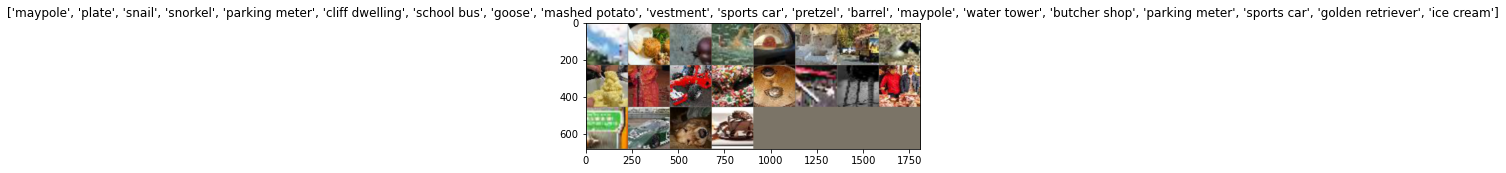

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classToLabel(class_names[x]) for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            counter = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    if counter > 0 and counter % 100 == 0:
                        print("Iteration: {} out of {} with Loss: {:.4f} and Accuracy: {:.4f}".format(counter, len(dataloaders['train']), loss, torch.sum(preds == labels.data) / torch.sum(preds)))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                counter += 1
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_conv = torchvision.models.resnet101(pretrained=True)

with torch.cuda.device('cuda:1'):
    torch.cuda.empty_cache()
    
device = torch.device('cuda:1')

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Iteration: 100 out of 5000 with Loss: 5.1491 and Accuracy: 0.0005
Iteration: 200 out of 5000 with Loss: 5.0069 and Accuracy: 0.0000
Iteration: 300 out of 5000 with Loss: 5.0457 and Accuracy: 0.0005
Iteration: 400 out of 5000 with Loss: 4.8625 and Accuracy: 0.0008
Iteration: 500 out of 5000 with Loss: 4.8103 and Accuracy: 0.0012
Iteration: 600 out of 5000 with Loss: 4.5693 and Accuracy: 0.0019
Iteration: 700 out of 5000 with Loss: 4.7713 and Accuracy: 0.0008
Iteration: 800 out of 5000 with Loss: 4.9998 and Accuracy: 0.0005
Iteration: 900 out of 5000 with Loss: 4.8714 and Accuracy: 0.0005
Iteration: 1000 out of 5000 with Loss: 4.4331 and Accuracy: 0.0020
Iteration: 1100 out of 5000 with Loss: 4.1426 and Accuracy: 0.0012
Iteration: 1200 out of 5000 with Loss: 4.2943 and Accuracy: 0.0024
Iteration: 1300 out of 5000 with Loss: 4.0409 and Accuracy: 0.0033
Iteration: 1400 out of 5000 with Loss: 4.3633 and Accuracy: 0.0013
Iteration: 1500 out of 5000 with Loss: 3.8767 and

Iteration: 1500 out of 5000 with Loss: 2.2238 and Accuracy: 0.0047
Iteration: 1600 out of 5000 with Loss: 3.5626 and Accuracy: 0.0020
Iteration: 1700 out of 5000 with Loss: 2.7392 and Accuracy: 0.0039
Iteration: 1800 out of 5000 with Loss: 3.0002 and Accuracy: 0.0046
Iteration: 1900 out of 5000 with Loss: 2.8599 and Accuracy: 0.0043
Iteration: 2000 out of 5000 with Loss: 3.2746 and Accuracy: 0.0025
Iteration: 2100 out of 5000 with Loss: 2.1443 and Accuracy: 0.0055
Iteration: 2200 out of 5000 with Loss: 2.3218 and Accuracy: 0.0043
Iteration: 2300 out of 5000 with Loss: 3.3945 and Accuracy: 0.0032
Iteration: 2400 out of 5000 with Loss: 3.0298 and Accuracy: 0.0026
Iteration: 2500 out of 5000 with Loss: 2.8709 and Accuracy: 0.0031
Iteration: 2600 out of 5000 with Loss: 3.0491 and Accuracy: 0.0032
Iteration: 2700 out of 5000 with Loss: 2.8498 and Accuracy: 0.0040
Iteration: 2800 out of 5000 with Loss: 3.0801 and Accuracy: 0.0040
Iteration: 2900 out of 5000 with Loss: 2.3619 and Accuracy: 0.

Iteration: 3000 out of 5000 with Loss: 3.4341 and Accuracy: 0.0032
Iteration: 3100 out of 5000 with Loss: 2.9874 and Accuracy: 0.0037
Iteration: 3200 out of 5000 with Loss: 2.5324 and Accuracy: 0.0039
Iteration: 3300 out of 5000 with Loss: 1.9294 and Accuracy: 0.0068
Iteration: 3400 out of 5000 with Loss: 2.6789 and Accuracy: 0.0033
Iteration: 3500 out of 5000 with Loss: 3.2326 and Accuracy: 0.0035
Iteration: 3600 out of 5000 with Loss: 2.3266 and Accuracy: 0.0040
Iteration: 3700 out of 5000 with Loss: 2.3584 and Accuracy: 0.0050
Iteration: 3800 out of 5000 with Loss: 2.9780 and Accuracy: 0.0023
Iteration: 3900 out of 5000 with Loss: 2.9895 and Accuracy: 0.0041
Iteration: 4000 out of 5000 with Loss: 3.1606 and Accuracy: 0.0033
Iteration: 4100 out of 5000 with Loss: 3.0296 and Accuracy: 0.0045
Iteration: 4200 out of 5000 with Loss: 2.7061 and Accuracy: 0.0043
Iteration: 4300 out of 5000 with Loss: 2.0499 and Accuracy: 0.0030
Iteration: 4400 out of 5000 with Loss: 2.0592 and Accuracy: 0.

Iteration: 4500 out of 5000 with Loss: 2.9544 and Accuracy: 0.0037
Iteration: 4600 out of 5000 with Loss: 2.5726 and Accuracy: 0.0040
Iteration: 4700 out of 5000 with Loss: 3.2827 and Accuracy: 0.0034
Iteration: 4800 out of 5000 with Loss: 2.4882 and Accuracy: 0.0040
Iteration: 4900 out of 5000 with Loss: 3.1845 and Accuracy: 0.0024
train Loss: 2.6773 Acc: 0.3998
Iteration: 100 out of 5000 with Loss: 11.4277 and Accuracy: 0.0000
Iteration: 200 out of 5000 with Loss: 9.7138 and Accuracy: 0.0000
Iteration: 300 out of 5000 with Loss: 8.8608 and Accuracy: 0.0000
Iteration: 400 out of 5000 with Loss: 10.2263 and Accuracy: 0.0000
val Loss: 10.0620 Acc: 0.0055

Epoch 7/24
----------
Iteration: 100 out of 5000 with Loss: 1.9640 and Accuracy: 0.0040
Iteration: 200 out of 5000 with Loss: 2.5559 and Accuracy: 0.0043
Iteration: 300 out of 5000 with Loss: 1.8636 and Accuracy: 0.0053
Iteration: 400 out of 5000 with Loss: 3.1800 and Accuracy: 0.0021
Iteration: 500 out of 5000 with Loss: 2.2897 and Ac

Iteration: 500 out of 5000 with Loss: 2.8568 and Accuracy: 0.0042
Iteration: 600 out of 5000 with Loss: 2.5094 and Accuracy: 0.0042
Iteration: 700 out of 5000 with Loss: 2.8718 and Accuracy: 0.0033
Iteration: 800 out of 5000 with Loss: 2.1275 and Accuracy: 0.0040
Iteration: 900 out of 5000 with Loss: 2.6211 and Accuracy: 0.0043
Iteration: 1000 out of 5000 with Loss: 1.9227 and Accuracy: 0.0055
Iteration: 1100 out of 5000 with Loss: 2.4169 and Accuracy: 0.0039
Iteration: 1200 out of 5000 with Loss: 2.5607 and Accuracy: 0.0036
Iteration: 1300 out of 5000 with Loss: 3.4870 and Accuracy: 0.0040
Iteration: 1400 out of 5000 with Loss: 3.0272 and Accuracy: 0.0038
Iteration: 1500 out of 5000 with Loss: 2.8286 and Accuracy: 0.0048
Iteration: 1600 out of 5000 with Loss: 2.2605 and Accuracy: 0.0044
Iteration: 1700 out of 5000 with Loss: 3.3621 and Accuracy: 0.0036
Iteration: 1800 out of 5000 with Loss: 2.4818 and Accuracy: 0.0039
Iteration: 1900 out of 5000 with Loss: 2.3085 and Accuracy: 0.0044


Iteration: 2000 out of 5000 with Loss: 2.1974 and Accuracy: 0.0044
Iteration: 2100 out of 5000 with Loss: 2.0842 and Accuracy: 0.0046
Iteration: 2200 out of 5000 with Loss: 3.0418 and Accuracy: 0.0053
Iteration: 2300 out of 5000 with Loss: 2.5799 and Accuracy: 0.0050
Iteration: 2400 out of 5000 with Loss: 2.5803 and Accuracy: 0.0052
Iteration: 2500 out of 5000 with Loss: 2.0056 and Accuracy: 0.0053
Iteration: 2600 out of 5000 with Loss: 2.8540 and Accuracy: 0.0041
Iteration: 2700 out of 5000 with Loss: 2.6808 and Accuracy: 0.0024
Iteration: 2800 out of 5000 with Loss: 2.5459 and Accuracy: 0.0046
Iteration: 2900 out of 5000 with Loss: 2.8722 and Accuracy: 0.0041
Iteration: 3000 out of 5000 with Loss: 3.1581 and Accuracy: 0.0029
Iteration: 3100 out of 5000 with Loss: 2.4640 and Accuracy: 0.0056
Iteration: 3200 out of 5000 with Loss: 2.3316 and Accuracy: 0.0045
Iteration: 3300 out of 5000 with Loss: 3.1232 and Accuracy: 0.0037
Iteration: 3400 out of 5000 with Loss: 2.1628 and Accuracy: 0.

Iteration: 3500 out of 5000 with Loss: 2.6677 and Accuracy: 0.0050
Iteration: 3600 out of 5000 with Loss: 2.6587 and Accuracy: 0.0048
Iteration: 3700 out of 5000 with Loss: 2.8403 and Accuracy: 0.0045
Iteration: 3800 out of 5000 with Loss: 2.8039 and Accuracy: 0.0063
Iteration: 3900 out of 5000 with Loss: 2.5237 and Accuracy: 0.0039
Iteration: 4000 out of 5000 with Loss: 3.5871 and Accuracy: 0.0030
Iteration: 4100 out of 5000 with Loss: 2.4940 and Accuracy: 0.0037
Iteration: 4200 out of 5000 with Loss: 3.0555 and Accuracy: 0.0030
Iteration: 4300 out of 5000 with Loss: 3.2127 and Accuracy: 0.0024
Iteration: 4400 out of 5000 with Loss: 2.4786 and Accuracy: 0.0028
Iteration: 4500 out of 5000 with Loss: 2.2779 and Accuracy: 0.0061
Iteration: 4600 out of 5000 with Loss: 2.4201 and Accuracy: 0.0034
Iteration: 4700 out of 5000 with Loss: 1.8442 and Accuracy: 0.0052
Iteration: 4800 out of 5000 with Loss: 1.3669 and Accuracy: 0.0081
Iteration: 4900 out of 5000 with Loss: 2.3206 and Accuracy: 0.

train Loss: 2.6003 Acc: 0.4159
Iteration: 100 out of 5000 with Loss: 10.5058 and Accuracy: 0.0000
Iteration: 200 out of 5000 with Loss: 9.6515 and Accuracy: 0.0000
Iteration: 300 out of 5000 with Loss: 10.1150 and Accuracy: 0.0000
Iteration: 400 out of 5000 with Loss: 9.2876 and Accuracy: 0.0006
val Loss: 10.4008 Acc: 0.0053

Epoch 16/24
----------
Iteration: 100 out of 5000 with Loss: 2.0513 and Accuracy: 0.0051
Iteration: 200 out of 5000 with Loss: 2.4003 and Accuracy: 0.0047
Iteration: 300 out of 5000 with Loss: 3.3506 and Accuracy: 0.0025
Iteration: 400 out of 5000 with Loss: 2.0324 and Accuracy: 0.0056
Iteration: 500 out of 5000 with Loss: 2.3133 and Accuracy: 0.0036
Iteration: 600 out of 5000 with Loss: 1.9880 and Accuracy: 0.0053
Iteration: 700 out of 5000 with Loss: 3.3580 and Accuracy: 0.0023
Iteration: 800 out of 5000 with Loss: 3.1300 and Accuracy: 0.0023
Iteration: 900 out of 5000 with Loss: 2.1134 and Accuracy: 0.0057
Iteration: 1000 out of 5000 with Loss: 2.7290 and Accur

Iteration: 1000 out of 5000 with Loss: 2.2112 and Accuracy: 0.0048
Iteration: 1100 out of 5000 with Loss: 3.2450 and Accuracy: 0.0027
Iteration: 1200 out of 5000 with Loss: 3.0603 and Accuracy: 0.0020
Iteration: 1300 out of 5000 with Loss: 2.6533 and Accuracy: 0.0040
Iteration: 1400 out of 5000 with Loss: 3.4718 and Accuracy: 0.0031
Iteration: 1500 out of 5000 with Loss: 2.5799 and Accuracy: 0.0048
Iteration: 1600 out of 5000 with Loss: 2.0455 and Accuracy: 0.0057
Iteration: 1700 out of 5000 with Loss: 2.8457 and Accuracy: 0.0034
Iteration: 1800 out of 5000 with Loss: 3.0047 and Accuracy: 0.0022
Iteration: 1900 out of 5000 with Loss: 2.1300 and Accuracy: 0.0051
Iteration: 2000 out of 5000 with Loss: 1.9814 and Accuracy: 0.0055
Iteration: 2100 out of 5000 with Loss: 2.2815 and Accuracy: 0.0045
Iteration: 2200 out of 5000 with Loss: 2.2964 and Accuracy: 0.0044
Iteration: 2300 out of 5000 with Loss: 2.7471 and Accuracy: 0.0025
Iteration: 2400 out of 5000 with Loss: 2.0266 and Accuracy: 0.

Iteration: 4600 out of 5000 with Loss: 1.9628 and Accuracy: 0.0076
Iteration: 4700 out of 5000 with Loss: 2.8733 and Accuracy: 0.0033
Iteration: 4800 out of 5000 with Loss: 2.9428 and Accuracy: 0.0030
Iteration: 4900 out of 5000 with Loss: 1.9552 and Accuracy: 0.0052
train Loss: 2.5970 Acc: 0.4163
Iteration: 100 out of 5000 with Loss: 9.9132 and Accuracy: 0.0000
Iteration: 200 out of 5000 with Loss: 10.3498 and Accuracy: 0.0000
Iteration: 300 out of 5000 with Loss: 10.3752 and Accuracy: 0.0000
Iteration: 400 out of 5000 with Loss: 10.7703 and Accuracy: 0.0000
val Loss: 10.2407 Acc: 0.0052

Epoch 21/24
----------
Iteration: 100 out of 5000 with Loss: 2.9093 and Accuracy: 0.0027
Iteration: 200 out of 5000 with Loss: 3.1027 and Accuracy: 0.0038
Iteration: 300 out of 5000 with Loss: 2.8599 and Accuracy: 0.0046
Iteration: 400 out of 5000 with Loss: 3.1607 and Accuracy: 0.0022
Iteration: 500 out of 5000 with Loss: 2.1670 and Accuracy: 0.0048
Iteration: 600 out of 5000 with Loss: 2.3762 and A

Iteration: 600 out of 5000 with Loss: 2.2416 and Accuracy: 0.0064
Iteration: 700 out of 5000 with Loss: 1.7493 and Accuracy: 0.0067
Iteration: 800 out of 5000 with Loss: 2.1078 and Accuracy: 0.0050
Iteration: 900 out of 5000 with Loss: 2.4518 and Accuracy: 0.0048
Iteration: 1000 out of 5000 with Loss: 2.7720 and Accuracy: 0.0042
Iteration: 1100 out of 5000 with Loss: 2.6725 and Accuracy: 0.0041
Iteration: 1200 out of 5000 with Loss: 2.9129 and Accuracy: 0.0032
Iteration: 1300 out of 5000 with Loss: 2.7557 and Accuracy: 0.0041
Iteration: 1400 out of 5000 with Loss: 2.6438 and Accuracy: 0.0026
Iteration: 1500 out of 5000 with Loss: 2.2434 and Accuracy: 0.0058
Iteration: 1600 out of 5000 with Loss: 2.3593 and Accuracy: 0.0045
Iteration: 1700 out of 5000 with Loss: 2.4110 and Accuracy: 0.0045
Iteration: 1800 out of 5000 with Loss: 2.8654 and Accuracy: 0.0030
Iteration: 1900 out of 5000 with Loss: 2.7180 and Accuracy: 0.0043
Iteration: 2000 out of 5000 with Loss: 2.6013 and Accuracy: 0.0042

In [12]:
for inputs, targets in dataloaders['train']:
    print(targets.to(device))

tensor([161, 143, 170, 149,  18, 129,  64,  83,   5, 198, 166,  12, 183, 172,
          6, 156,  70,  86,  16, 137], device='cuda:1')
tensor([ 62,  37, 135,  20,  14, 196, 136, 173, 159,  47,  90,  41,  59,  13,
        164,  19, 180,  12, 195, 134], device='cuda:1')
tensor([ 82,   1,  84, 145,  15, 172,  56, 166,  28,  54, 105, 101, 189,  62,
          7, 165,  60, 105, 147, 163], device='cuda:1')
tensor([  4,   5,  88, 183, 151, 169,  22, 110, 101,  48, 159,  39, 153, 154,
        161, 166,  20, 135,  85,  94], device='cuda:1')
tensor([ 91,  51,  39,  71, 116,  15,  59, 137, 197, 105,  21,  77, 199, 167,
         33, 181, 140, 157,  43, 141], device='cuda:1')
tensor([142, 116,  78, 191,  65,  54,  24, 194,  60, 197,  97,  98,  62, 118,
         25,  30,  67,  19,  81, 143], device='cuda:1')
tensor([144,  27, 174, 119,  30, 194,  98, 166, 176, 144,  45,   6,  99,  43,
         69,  18,  38, 119, 161,   6], device='cuda:1')
tensor([141, 105,  25,  62, 118,  45, 129, 120,  41, 145,  86,

tensor([ 86, 109,  54,  26, 149, 172, 182,   7,  42,  89, 102,  16,  71, 147,
        140,  45,  73, 167,  90, 186], device='cuda:1')
tensor([ 31,  35, 112,  66, 152, 133, 119, 142, 139,  77,  21, 143, 109,  41,
         20, 155,  21,  66, 135, 122], device='cuda:1')
tensor([183,  27, 191, 190, 194,   6,  21,  77,  35,  68,  47,  41,   9,  42,
          7, 190,  22, 181, 157, 104], device='cuda:1')
tensor([ 55,  24,  90,  80,  67,  21,  59,  31, 166, 147,   6,  50, 141, 185,
         35, 171, 198, 140,  41,   3], device='cuda:1')
tensor([105, 143,  59, 169, 111,   5, 102,  15, 181,  93, 130,  63, 157, 181,
        112, 189,  48,  63,   0, 109], device='cuda:1')
tensor([ 90,  70, 161, 193,   2, 117, 114, 113, 198,  88, 110,   4,  84, 159,
         36, 112, 181, 116, 149, 175], device='cuda:1')
tensor([ 13,  92,  15, 169,  96,  24, 163,  67,  44, 174,  80, 138, 104, 199,
        113,  66,  81, 101,  36, 176], device='cuda:1')
tensor([ 45,  10, 136,  94, 178,  25,   3,  93,  85,   7,  99,

tensor([ 34,  39,  34,  58, 185,  60, 130, 116, 193,  47, 108, 136,  95, 175,
         82,  53,  53, 185,  86,  70], device='cuda:1')
tensor([113, 144, 141,  65, 196, 142,  16,  53, 160,  24,  57,  29,  74, 158,
         33,  81, 159,  53, 159, 194], device='cuda:1')
tensor([166, 142,  32, 108, 165, 162,  49,  45,   1,   9, 183,  44, 187, 157,
         67, 124, 158, 180,  47,  62], device='cuda:1')
tensor([114, 176, 111,  21, 157,  57, 160, 198, 110,  22, 146, 108,  26,  98,
         50,  91, 120, 164, 129, 166], device='cuda:1')
tensor([145, 168,  73, 193,  33, 145,  38,  84, 102,  89,  19, 157,  84,   1,
         99,  34, 103, 166,  72,  95], device='cuda:1')
tensor([ 85, 148,  27,  59,  55, 192, 109,  56,  15,  60,  63,  44, 169,  73,
        174,  66,  55, 109, 110, 158], device='cuda:1')
tensor([ 56, 181,   3, 141,  86, 156,  40, 189,  95,  32, 110,  38,  80, 109,
        174,  13, 184,   5, 191, 183], device='cuda:1')
tensor([128,  29,   5,  38,  48,  27,   1,   7,  29,  36,  17,

tensor([140,  34,  80,  62, 113, 174,  61, 103, 131,  56, 171, 187, 118,  17,
        166, 178,  63,  22,  88, 108], device='cuda:1')
tensor([ 16,  35, 104, 103, 116, 108, 126, 179, 113, 139, 156,  12, 157,  99,
        198,  85,  57, 130, 178,  48], device='cuda:1')
tensor([199, 105,  68, 148,  75,  43,   5, 136, 115, 140,  56,  13,  83, 198,
         76,  90, 153, 169,  88, 142], device='cuda:1')
tensor([ 52,  95, 106,  21,  51,  33, 109, 103, 190, 124,  98, 103, 128, 180,
        113, 136,  46,  73, 125,  26], device='cuda:1')
tensor([ 62, 194, 183, 174,  29, 174,  40, 117, 196, 196, 173, 197,  79, 190,
         24, 144, 197, 161,  52,   5], device='cuda:1')
tensor([ 56, 124,  18, 114,   7,  69,  39, 184,  67,  93,   2, 174, 145, 116,
        172, 133, 180, 132, 176, 135], device='cuda:1')
tensor([184, 128,  89,  95, 150, 190,  82, 167, 130, 179, 105,  48,  74,  99,
         38, 188, 151,  14, 108, 165], device='cuda:1')
tensor([128,  26,  94,  27, 104,  39,  69, 184, 127, 113,   8,

tensor([ 79,  32, 158, 196, 136, 142, 134, 184, 187,  70,  49, 166,  32, 133,
         50, 122, 108,  88,  33,  66], device='cuda:1')
tensor([110,  64,  37,  68,  67,  11, 112,  95,  89, 127, 129,  53,  47, 173,
        114,  71, 149, 193,  69, 124], device='cuda:1')
tensor([ 56,  91, 184, 145,  70, 147, 125,  32,  12,  83,  70, 132, 180,  73,
        143, 113,  44, 104,  73,  48], device='cuda:1')
tensor([184,  52,  68,  65,  14, 149,  12,  38, 129,  59,   9, 134,  64, 133,
        110, 156, 157, 143, 172,  65], device='cuda:1')
tensor([  0, 117, 197,  77,  42, 184,  35, 149,   7,   9,  86,  92,  54, 174,
         50,  65, 175, 149, 161, 168], device='cuda:1')
tensor([ 30, 184,  12, 171, 116, 134, 100, 172, 143, 177,  49, 116, 152, 199,
         90,  61, 163, 133, 101, 171], device='cuda:1')
tensor([ 83,  86,  16,  52,  25,   4, 164, 127,  86,  59,  89, 171,   1,   9,
         21,  63,  33, 105,  52, 135], device='cuda:1')
tensor([129, 112,  93, 111,   2,  58,  82,  45, 110,  33, 173,

tensor([103, 162,  87,  86,  63,  69, 197,  50, 131,  12, 193,  48, 109,  57,
        137, 187,  47,   5,  55, 175], device='cuda:1')
tensor([166,  14, 195, 141,  62, 199,  83,  85, 183, 190, 166, 105,  74, 195,
         33, 134,  59, 155,  72,  50], device='cuda:1')
tensor([157, 183,  93, 138, 163, 151,  38, 106,  65, 131,  64, 138,  11, 175,
         30,  70, 189, 139,  46,  20], device='cuda:1')
tensor([159, 175,  71,  94,  21,  39, 148,   1, 124, 194,  47,  95, 116,  54,
        150,  29, 170, 126, 130,   7], device='cuda:1')
tensor([ 35,  90,  33, 143, 184,  16,  38,   4, 149, 152,  43, 162,  42, 142,
         25,  14,  46,  80, 176,  91], device='cuda:1')
tensor([104, 185,  70, 119,  67, 106, 100, 113, 121, 198, 186,  35,  65, 180,
         82, 155,  95, 157, 108, 182], device='cuda:1')
tensor([  0, 104, 178, 156,  87,  84, 156,   5, 194,   6, 142,  28,  89,  33,
         82, 159,  80, 177, 146, 127], device='cuda:1')
tensor([ 60,  60, 145,  88, 146,  94, 156,  77,  14,  82, 138,

tensor([ 64,  58,  62, 164,  99, 111,  63,  81,  88,  17, 119,  31,  57,  59,
        157,  19, 145,   3,  60, 122], device='cuda:1')
tensor([ 88, 157, 107,  83, 125,   8, 129,  66, 117, 136,  59, 120,  20, 156,
        185, 156,  80, 175,  85, 188], device='cuda:1')
tensor([101, 108,   8,  59,  24,  43, 115, 166,  35, 158,  51, 152,  38, 112,
         58,   7,  64, 108,  18,  20], device='cuda:1')
tensor([  2, 140, 103, 197,  68,  17, 108,  60,  16,  16, 148,  75, 140,  49,
        187,   4, 128, 113, 197,  22], device='cuda:1')
tensor([ 69, 187, 147, 183, 194,  63, 112, 176, 191,  15,  61, 194, 173,  90,
        122,   3,  83, 141,  40, 161], device='cuda:1')
tensor([154, 150, 197,  60, 156,  84,  48,  20, 165,  55, 194,  41,  25, 166,
        136,  24,  76,  18, 166,  22], device='cuda:1')
tensor([151,  38, 181, 198, 188,  89, 141, 139,   8, 183,  82,  13, 109, 117,
        142,   8, 192, 197, 105, 189], device='cuda:1')
tensor([112,  10,  11,  66, 134,  63,   6,  86, 127,  29,  14,

tensor([ 89,  40, 199, 147, 128,  87, 124, 187, 137,  21, 156, 128, 144, 102,
         58,  67,   4, 197,  71,  94], device='cuda:1')
tensor([185, 185,  22, 170,  72,  73,  67, 140,  57, 187, 158,  99,  81, 122,
        130,  67,  84, 164,  66, 139], device='cuda:1')
tensor([174,  65, 172, 149, 172, 168, 150,  42,  12, 157, 172,  15, 178,  40,
        109,  50, 134,  94,  62, 153], device='cuda:1')
tensor([ 48, 199, 125,  27,  68, 164,   4,  90, 123, 164,  87, 165,   0,  87,
         37,  35,  75, 108, 183, 174], device='cuda:1')
tensor([170,  83,   1,  78, 105,  65, 135,  79, 160, 199, 142,  85, 144,  24,
        166,  99,  31,  60, 136,  93], device='cuda:1')
tensor([ 97, 196, 156,   1, 143, 144,   2, 150, 100, 111, 194,  44, 133,  92,
        104,  75,  96, 133, 127, 119], device='cuda:1')
tensor([170, 183,  38, 135,  23,  75, 193,  44,  18,  10,  94, 167,  24,  27,
         86,   7, 152, 160,  95,  42], device='cuda:1')
tensor([189, 123,  75, 116, 134, 114,  54,  77,  81,  68, 105,

tensor([191, 194, 140,  49, 143, 138, 189, 194, 184,  10,  47, 129, 182, 157,
        180, 127, 153,  27, 126, 136], device='cuda:1')
tensor([144,  60,   7,  90,  42, 185, 158, 167, 191,  74, 108,  40,   0, 136,
          4,  98, 159, 150,  71, 149], device='cuda:1')
tensor([160, 102,  10,  63, 177, 158,  72, 114,  34, 120,  28,  63, 153,  64,
        114,  73, 127, 168, 146,  83], device='cuda:1')
tensor([103,  20, 123,  33,  56,  15, 139, 131, 177,  19,   3, 118, 185,   8,
         86, 126,  57, 182, 100,  95], device='cuda:1')
tensor([116, 170,  70, 119,  40,  86, 182, 150,  54,  43,  33,  63,  99, 133,
        189, 166,  63,  94, 136, 126], device='cuda:1')
tensor([171,  11,  52,  83, 135, 110,  24,  76,  41, 106, 137, 164, 125, 194,
        108, 121, 108,  80,  44, 155], device='cuda:1')
tensor([ 62,  17,  36, 159, 117, 149, 189,  21,  45, 136, 128, 162,  68,  93,
         14,  34,  86, 113, 121, 109], device='cuda:1')
tensor([ 36,  45,  31,  46,  38, 125, 142,  31,  93, 179,  35,

tensor([164,  32, 165, 149, 161, 117, 123,  41, 131,  17,  24, 166,   9,  17,
        121, 147,  10,  68, 133, 190], device='cuda:1')
tensor([ 88,  93,  65, 158,  92,  82, 122, 141,  81,  33, 143,  81,  54, 165,
        156, 100, 139, 197, 164, 153], device='cuda:1')
tensor([153, 178, 113,  68, 105, 152, 155, 191,  13, 186, 150,  15,  21,  16,
        190,  68, 105, 187, 177,  48], device='cuda:1')
tensor([ 53, 182, 120,   2,  61,  53, 144,  43,  16, 179,  54,  54, 146, 133,
        182,  80, 123,  68,  75,  47], device='cuda:1')
tensor([104,  20,  59,  59,  47,  89, 126, 197, 175, 174, 196,  22, 197, 105,
        101, 146, 147,  26, 110,  67], device='cuda:1')
tensor([182,  83,  41, 188, 171,  37, 125,  49,  82,  95, 149,  76, 138,  74,
          3,  83, 188, 112,  77, 154], device='cuda:1')
tensor([ 38,  69,  23,   3,  89, 165, 109,  32,   6, 159, 194,  49, 107,  75,
        103,  71, 100, 135,  11, 194], device='cuda:1')
tensor([ 24, 175, 184, 124, 181,  86,  66, 181,  93,  13, 174,

tensor([ 11, 184,  12, 130,  83, 189,  93,  99, 120, 117, 150,  85, 155,  50,
         41, 197,  25,  20, 126,  18], device='cuda:1')
tensor([164, 196, 114, 192, 142, 112, 145, 156,  99,   4,  73, 186, 194, 115,
         79, 146, 150, 116,  54,  77], device='cuda:1')
tensor([129,  28, 167,  14, 186, 112,  75,  86, 173, 103, 177, 149,  94,  17,
         72,  59,  90, 153,  75,  84], device='cuda:1')
tensor([110,  64,  67, 149,  82, 182, 182,  63, 117,  82,   3,  84, 188, 116,
        124, 182, 122, 122, 108, 146], device='cuda:1')
tensor([136, 192,  90, 194,  58, 190,  10,  21,  83,  11, 130, 183, 115,  34,
        120,  77, 169, 167,  70, 197], device='cuda:1')
tensor([ 38,  57,  95, 120, 195, 143,  78, 163,  40, 178, 176,  94, 126, 196,
         25,  27,  94,  50,  58,   8], device='cuda:1')
tensor([119, 114,  27, 100,  69, 145,  19,  91,  39,  61,  83, 134,  68, 154,
         27, 166,  56, 117,   8, 189], device='cuda:1')
tensor([178,  61,   3,  67, 164, 169,  69, 164, 199, 150, 126,

tensor([  3, 102, 120,  75, 104,  57,  90,  17, 138,   7,   0,   2, 155, 152,
         62, 132, 112, 126, 132,  99], device='cuda:1')
tensor([ 94, 107, 174, 197,  25,  66,  11, 117,  39, 131,   5, 146, 194,  80,
         67, 132,  64,  20, 132,   1], device='cuda:1')
tensor([180, 133,  39,  13,  74,  60, 132,  79, 177,  52, 180, 191,  18,  21,
         51, 102, 164, 175,  16,  12], device='cuda:1')
tensor([ 46, 186,  92,  17,   5,   5, 117,  15,  23,  80, 138,  38,  71, 165,
        197, 143,  41,   3, 101,   5], device='cuda:1')
tensor([ 50,   1, 152, 131, 185, 139,  74,  29,   7, 197,   6,  61, 135, 163,
        160, 191, 147,   4,  82,  79], device='cuda:1')
tensor([ 43, 160,  67,  85,   9, 171,  19, 162, 116,  55,   9, 101, 136, 190,
        197,  38,  13,  15,  18,  30], device='cuda:1')
tensor([169, 117,  87,  94,  27,  29, 100, 173, 115, 141,   3,   0, 152,  40,
        111,  91,  33,  23,  36, 118], device='cuda:1')
tensor([142,  22,  51, 106, 160,   2, 134,  84, 146,  59,  56,

tensor([ 73, 114,   5, 108,  75, 109, 118,  49,  54,  57,  68, 107,  20, 163,
         88, 192, 145, 186,  22,  48], device='cuda:1')
tensor([ 87,  31, 158, 115, 150, 149,  87, 102, 156,   6,   2, 176, 176,   3,
         92, 133, 156, 184, 174, 186], device='cuda:1')
tensor([136, 158, 107,  26, 139,  22,  21,  74,  27, 165,  47,   9, 173,  38,
        104, 111,  41,  26, 109, 115], device='cuda:1')
tensor([ 39, 120,  30, 157,  15,  77,  47,  49, 123, 165, 145, 134,  44,   9,
         77, 199, 166, 135,   4, 117], device='cuda:1')
tensor([ 85, 101, 138,  80,  38, 108, 170, 156, 170, 108,  74, 179, 194,   5,
         72,  33,  39,  56,  68,  94], device='cuda:1')
tensor([109,  74, 109,  83, 108, 114,  16, 140, 159,  43, 191, 119, 137,  18,
        122,  91,  17,  27,  30,  41], device='cuda:1')
tensor([193, 169,  26,  50, 101, 191, 173, 182, 158,  68, 175, 149,  50, 160,
         31,  94, 128, 192, 177,  25], device='cuda:1')
tensor([189,  99, 191,  40,  37, 183, 126, 103, 146, 139,  32,

tensor([ 60,  18,  38,   6, 177, 124, 115, 170,  31, 135,  75, 120, 117, 110,
         19, 120, 161,  54, 122,  90], device='cuda:1')
tensor([190,  17,  86,  63, 177, 168, 102, 157, 155,  80, 133, 152, 195,  24,
        144,  10, 149, 194,  42,  61], device='cuda:1')
tensor([161, 118, 128,  81,   5, 112,  24,  12, 170,   2,  15,  42,  92, 159,
         38,  43,  37,  83, 120,  68], device='cuda:1')
tensor([ 30, 172,  18, 161,  27, 165, 116,   0, 156, 126,  22, 187, 151, 178,
         58, 101,  58,  12,  66, 124], device='cuda:1')
tensor([115, 183,  71,  99,  87, 116,  69,  40, 121, 111,  26,  61, 156,  51,
        102, 113, 126, 120, 174, 117], device='cuda:1')
tensor([  6, 171,  94,  17, 109, 104,   5, 174,  42,  46, 100,  19, 103,  33,
        121,  59, 174,  11, 179,  93], device='cuda:1')
tensor([138,  82, 150,  73, 148,  98, 143, 151, 178,  11,  76, 101, 142, 180,
        114,  48, 101,  16, 108,   4], device='cuda:1')
tensor([166, 187, 119, 116,   6,  37,  18,  13, 165,  55,  99,

tensor([ 65,  10, 196,  38,   5,   4,  40,  62,  85,  10, 112,  55, 134,  64,
         76, 161, 186,  59, 161, 123], device='cuda:1')
tensor([  7, 107, 118, 169, 103,  44,  62,  67,  31, 110,  28,  24, 123, 149,
         63,  60, 131, 181, 175,  10], device='cuda:1')
tensor([192,  89, 123, 103, 106, 153, 185,  29, 146, 111, 194,  80, 186,  70,
        181,  99,  71,  71,  15, 162], device='cuda:1')
tensor([143, 171, 144, 159, 164, 106,  53,   8,  20, 136, 172,  57, 195,   2,
        100,  93, 104,  14, 168,  33], device='cuda:1')
tensor([ 57, 162, 107, 143,  54,  97, 193, 107,  15,  94,  51,  57, 185,  19,
        187,  36,  35,  35,  82,  52], device='cuda:1')
tensor([155, 111, 164, 119, 170,  85, 175,  28, 183,  17, 111, 161, 112,  44,
         55,  68, 113,  87,  97, 186], device='cuda:1')
tensor([135,  22,  72, 184,  87,  41, 119, 105, 140, 171,  20,  48,  44,  17,
        175,  48, 138, 150, 166,   5], device='cuda:1')
tensor([ 46,  13,   8,  45,  52,  34, 185,  37, 107,  76,  59,

tensor([ 77, 146,  89,  65, 180, 118, 164,  77, 150,  89, 112, 106, 124, 117,
         57, 153, 130,  28,   8, 155], device='cuda:1')
tensor([ 96, 167, 175, 166, 148, 100, 112, 179,  19,  68,  25,  54, 170,  46,
        130,  52, 125,   3,  98,  54], device='cuda:1')
tensor([163,  16,  66,  93, 167, 167, 189, 144,  95,  21, 182, 111,  95, 140,
         52,  66,  79, 187, 151, 183], device='cuda:1')
tensor([166,  84, 113,  49, 184, 160,  67, 175, 125,  85,  76, 114,  74,  17,
        106,  23, 138, 150, 127, 119], device='cuda:1')
tensor([  9,  33, 110, 160, 180,  53,  96, 132, 137, 197, 154, 112, 115,  83,
          5, 106,  77, 193, 133, 188], device='cuda:1')
tensor([113, 141, 164,  77, 134,  64, 193, 124, 155,  21, 198, 138, 186, 133,
          4, 168,  51,  90,  74, 194], device='cuda:1')
tensor([ 50,  15, 146, 175,  47, 196, 113, 113,  85, 138,  39,  92, 100, 177,
         42,  46, 146, 162, 110, 168], device='cuda:1')
tensor([ 25, 108,  76, 152, 129, 182, 199,  66, 168, 103,  37,

tensor([ 43,  17,  42,  18, 193,  60, 117, 167, 169,  95, 171,  53,  60, 183,
         87,  34, 176, 192, 199, 100], device='cuda:1')
tensor([ 85,  56, 158, 108, 133, 187,  80, 191,  87, 184,  34,  88, 158,  71,
         99, 114,  88, 116,  58,  73], device='cuda:1')
tensor([ 47, 110, 167, 135, 155, 187, 117, 132, 117,  34, 120,   9,  19,  93,
         78, 124,  81, 157, 193, 129], device='cuda:1')
tensor([189, 154,  52, 170, 186,  85, 195, 122,  11,  23,   3, 155,  85,  48,
         76, 134, 142,   8,  75,  49], device='cuda:1')
tensor([ 45,  56,   2,  71, 112,  76,   8,  78,  68,  63,  62,  11,  42, 199,
        171, 199, 185,  55, 119,  81], device='cuda:1')
tensor([ 65, 165,  88, 123, 108,  38,  18, 179, 121,  96,  67,  82, 172,   5,
        197, 164,   0, 107,  24,  54], device='cuda:1')
tensor([169,   4,  29, 148,   1,  13, 194, 144,  32, 105,  66,  19,  62,  97,
         93, 144,  15, 105,  43,  15], device='cuda:1')
tensor([180,  38, 114,  36,  81,  86,   5,  23, 162,  45,  71,

tensor([194, 186,   4, 194,  54, 197,  91,  76, 124,  42, 158,  51,   6, 127,
         16, 197, 177,  53, 122, 182], device='cuda:1')
tensor([187, 177,  12,   4,  91,  98, 168,  87,  79, 187, 171,  12,  94, 136,
         30,  44, 198, 134, 163, 173], device='cuda:1')
tensor([137, 140, 102,  83,  46, 189,   1, 158,   3,  57,  77,  17,  72,   5,
         78, 111, 140, 156, 163,  59], device='cuda:1')
tensor([120, 180, 118, 173,   4, 147, 194,  57, 199, 179, 159, 197,  82, 124,
         32, 193, 174, 148, 121,  12], device='cuda:1')
tensor([ 94,  14, 174, 130, 175, 120,  42,  21,  58,   1,  22,  16,  12,  75,
        121, 117, 186,   0, 158,  48], device='cuda:1')
tensor([ 89, 135,  66, 173,  40,  52,  57, 127,  71,  65, 167,  42, 122, 138,
         34,  32, 177, 120,  71,   4], device='cuda:1')
tensor([160,  43, 120, 153, 114, 195, 151, 112, 148,  58, 118,  38, 139,  66,
         65,  96, 155,  99, 145, 130], device='cuda:1')
tensor([ 23, 110,  42, 105, 195, 177,  81, 174,  58, 116, 159,

tensor([ 77,  62,  86,  52,  54,  84, 122, 138,  36, 155,  82,  98, 190,  88,
         28,  48,  30,  91, 114,  35], device='cuda:1')
tensor([ 10,  18,  82, 110,  60, 116,   4,  25, 171,  17, 183, 133,  28, 182,
         43,  77, 185, 162, 140, 117], device='cuda:1')
tensor([  8,  89, 109,  65, 167, 160, 188, 196, 139, 149,  10,  41, 109,  86,
         39,  56,  64, 197,   2,  66], device='cuda:1')
tensor([159, 175, 197, 164, 160, 141, 188,  36,  43, 137,  87, 176,  27, 138,
         45,  74,  11, 189, 135,  14], device='cuda:1')
tensor([ 96,  31,   0,   3, 169,  83, 171,  31, 175,  86, 140, 127, 173, 112,
          7, 123,  74, 165, 115,  31], device='cuda:1')
tensor([ 46,  73, 149, 109,  86, 161,  47,  27, 121, 103,  83,  88, 131,  78,
        138, 187,   1,  45,  93, 128], device='cuda:1')
tensor([142, 135, 131, 154,   1, 145,  26,  66,  93,  53, 169,  17, 190, 159,
        193, 166, 164, 157, 120, 150], device='cuda:1')
tensor([172, 100, 185, 163, 107, 187,  96, 196, 117, 115, 177,

tensor([129,  63,  81, 140,  71,  42, 191,  10,  70, 167,  68, 198, 102, 179,
         40, 195, 149,  36,  25,  13], device='cuda:1')
tensor([195,  96,  58,  90, 179, 130, 127,  71, 112,   0,  34, 115, 194, 145,
        192, 199,  44, 123,  72,  77], device='cuda:1')
tensor([ 20,  20, 102, 119,  13, 146, 115, 132, 175,  29,  11, 145,  23,   4,
         94,  42, 184, 172,  34,  15], device='cuda:1')
tensor([ 87,  10, 181,  60,  87, 131, 139,  70, 121,  10,  87,   2,  18,  44,
        188, 111,  65, 156, 104, 147], device='cuda:1')
tensor([ 22, 185,  19,  57,   5, 118, 121, 190,  29, 158,  25, 170, 116, 144,
         33, 100,  46,  24,  31,  60], device='cuda:1')
tensor([128,  78, 109, 184,  21, 150,  16,  14,  77,   1,  36, 183,   6,   1,
        155, 119,  98, 122,  89, 139], device='cuda:1')
tensor([116, 157, 127,  95, 175, 179,  14,  65, 144, 102, 132,  44, 131, 190,
         28, 198, 142, 104, 166, 186], device='cuda:1')
tensor([114, 187,  74, 162, 140,  45, 189, 111, 113, 178,  96,

tensor([171, 194, 179, 188,  95,  53, 122,  59,  56, 188,  36,  74,  47,  96,
         70, 127, 106, 168,  11, 194], device='cuda:1')
tensor([110, 145, 194, 153,  45,  31, 105,  81, 158, 122,  59,  26,   7, 105,
         95, 179,  27, 153, 193,   2], device='cuda:1')
tensor([ 19,  73, 144, 105,  17,  88, 128,  84,  77, 192,  85, 197,  18,  75,
          8, 169,  67, 157,  54,  44], device='cuda:1')
tensor([ 29, 178,  65, 104, 125,  21, 123,  28, 172,  27, 114,  92,   3,  17,
        139,   7,  31, 137, 163, 193], device='cuda:1')
tensor([161, 188,  54, 149, 154, 185,  95,  81, 112, 187,  55, 128,  99, 103,
         23,  65, 132, 117,  29, 107], device='cuda:1')
tensor([165,  86, 130,  45, 186,  56,  20,  70,  19, 134,  16,  83, 151,   7,
        151, 156, 179,  42,  88, 105], device='cuda:1')
tensor([177,  51,  21, 133, 124,  37,  77,  32,  19, 122,  56,  35, 172,  49,
         54,  89, 124,  21, 170,  53], device='cuda:1')
tensor([ 38, 197, 100, 135, 150, 166, 123, 144,  96, 127, 152,

tensor([190,  29,  14,  59,  73,  75, 179, 141, 190,  81, 185,   4,  76, 175,
        131,  86, 119, 156, 129, 102], device='cuda:1')
tensor([ 70,  43, 147, 161,   8, 169,  61,  15,  32,  14,  95, 110, 167,  47,
        178,  38,  69, 105, 112,  31], device='cuda:1')
tensor([155, 102,  33, 132,  82,  47,   2,  39,  38, 180,  55,  80, 196, 142,
        134, 119,  19,  34, 199, 107], device='cuda:1')
tensor([106, 135, 184, 113, 100, 193,  11,  77,  83,  22, 121,  87,  72, 106,
         83, 103,   9, 129,  74, 101], device='cuda:1')
tensor([121,  18, 193, 111,  98,  90,  26, 193,  15,  19,  79, 107,  70, 101,
        180, 181,  16, 140, 133,  44], device='cuda:1')
tensor([163,  92, 118, 140,  21,  69,  16, 168, 193,   2,  59, 158,  39,  62,
        112,  19, 117, 174, 137, 161], device='cuda:1')
tensor([ 40,  94,  21,  93,  87,  52,  48, 195,  31, 170,  19,  51,  12,  32,
         60,  99, 126,  66, 143,  22], device='cuda:1')
tensor([146, 155, 107, 191,  24, 174, 136,  58,  46, 136, 175,

tensor([177,  82, 134, 197,  91, 190, 113, 143,  62,  43,  68,  27,  46,  87,
         12, 138, 155, 176, 112,  97], device='cuda:1')
tensor([173, 176, 120,  62,  36, 152,  28,  66,  19,  82,  30, 123,  40,  36,
        158,  86, 119,  44,   9, 184], device='cuda:1')
tensor([195, 199, 144,  82, 172,  62,  53,  66,  11, 109,  74,  71, 184,  66,
         90,  30,  58, 149, 133, 118], device='cuda:1')
tensor([ 75, 125,  77, 133,  77,  78,  70,  47, 169, 114,  63,  51,  50,  43,
         31, 130, 132,  91, 152, 180], device='cuda:1')
tensor([114,  21, 156, 169,  46, 146, 198,  97,  67,  52,  57,  66, 167, 158,
         77,  18,   4, 159, 126,  57], device='cuda:1')
tensor([ 76,   1,  59,   8,  10, 149, 126, 176,  89,  41,   8, 169, 146, 137,
        161, 119, 176, 182, 163,  96], device='cuda:1')
tensor([124,  27, 119, 118,  65, 185, 182, 100,  88, 136,  97,  89,  44, 137,
         86, 194,  34, 142,  85, 138], device='cuda:1')
tensor([ 26, 127,  95, 186,  10, 145, 100,  49,  44, 115, 111,

tensor([ 67, 158,  37, 178,  10,  31, 102, 186,  78,  40,  98,  99,  72, 141,
         25,  37,  27, 127,  35, 176], device='cuda:1')
tensor([ 88, 165, 166,  19, 157,  94, 162, 105,   5,  11,  77, 165, 128,  64,
        106,  26, 182, 195, 115, 182], device='cuda:1')
tensor([122,  51, 199, 155,  44,  78,  40, 102,  11,  76, 166, 193, 168, 159,
        167,  18,  63, 193, 106,  19], device='cuda:1')
tensor([  7,   6,  51, 105,  11, 103,  67, 190,  86,  41,  72, 159, 175, 138,
        169,  72,  29, 157,  37,  44], device='cuda:1')
tensor([ 37, 130,  82,  19, 143, 133,  33, 151,  12,  12,   3, 169, 138, 145,
         33, 135, 188, 161, 194,  79], device='cuda:1')
tensor([ 19, 160, 132, 175,  84,  46,  74,   7,   9, 113, 188,  35, 173, 196,
        150,   9, 174, 155, 104, 135], device='cuda:1')
tensor([137, 133,  20,  23, 134,   6,  33,  13, 123,   7, 184,  46, 175,   4,
         25,  23,  85, 189,  43, 198], device='cuda:1')
tensor([ 85,  52,  70,  23,  90,  32,  31,  45,  10, 180,  39,

tensor([125, 171, 126,  99,  34, 140, 118,  43,  67, 168, 153, 195, 111,  67,
        126, 197,  71, 130,  12, 173], device='cuda:1')
tensor([ 31, 165, 195,  36,  48, 196,  78, 188,   6,   0,  56,  15, 123,  59,
         51,   4,  19, 159,   2, 128], device='cuda:1')
tensor([199,  24,  75, 107, 111,   3,  56,  10, 166,  72, 125,  49, 143,  13,
         82,  99, 114, 146,  10,  69], device='cuda:1')
tensor([105, 168, 165,  21,   6, 192, 148, 116, 193,  65, 170, 140,  72, 120,
         62, 184, 122, 147,  87, 188], device='cuda:1')
tensor([ 41, 111, 136,   7,  22,  73, 162, 161,  71,  81,  60, 175,   0, 153,
         65, 169,  52, 199,  28, 103], device='cuda:1')
tensor([157, 171,  16,  80,  98,   8, 150,  35, 189,  31,  57,  67,  50,  46,
        143,  88, 132,  71,  44, 121], device='cuda:1')
tensor([120, 194, 165,  81,  73, 115, 149,  94,  49, 100,  10,  92,  51,  52,
         89, 177,  77,  89,  47, 148], device='cuda:1')
tensor([ 93, 134,  25, 121,  63,  80, 150,  54, 152, 133,  47,

tensor([ 39,  81,  42, 108, 152,  46, 192,  91,  19, 126, 152, 179, 159, 130,
          6,  96, 118, 112, 111, 133], device='cuda:1')
tensor([147, 192,   8,  82,  68, 160, 185, 179, 109, 108,  61,  50,  59, 188,
         53,  65,  84, 190,   5,  43], device='cuda:1')
tensor([ 84,  20,  46, 116,  16,  54, 183,  56, 119,  22,   2,  22, 164,  82,
         57, 105, 145,  23,  46, 145], device='cuda:1')
tensor([ 72, 118, 148, 155, 148, 126,  85,  47,  92, 189, 105, 179, 141,  54,
          0, 138,  90, 190, 194,  87], device='cuda:1')
tensor([105, 156, 130,  32,  53, 104, 104,  94, 115,  55,  74, 110,  34, 199,
        153, 149, 134, 172, 133, 180], device='cuda:1')
tensor([123,  97, 178, 150, 166, 103, 131, 155,  16, 150, 189, 167,  34, 142,
         63,  81, 184, 166,  63,   8], device='cuda:1')
tensor([ 98, 125,  64,  54,  70, 169, 130, 170,  21, 123, 151,  10,  73,  91,
        144, 190,   5,  65,  15,  95], device='cuda:1')
tensor([ 19,  63,  96, 163,  48, 152, 108, 118, 100, 149, 149,

tensor([ 42,  96,  92, 181,  41,  66,  52,  82, 127,  74,  73, 134, 152, 161,
        168,  13, 176, 114, 176,  76], device='cuda:1')
tensor([178,   8,  11,  92,  39, 110,  75, 138,  53,  18,  26,  56, 117, 175,
        163,  81,  97, 185,   2,   7], device='cuda:1')
tensor([158, 192, 145, 173, 195, 159, 168, 157,  86, 105,  30, 123, 119, 117,
        133, 110, 122,  84,  62,  25], device='cuda:1')
tensor([141,  64, 103,  32,  11,  73,  21,  97, 162,  94,  91, 135,   1, 156,
         32,  39,  98,  45, 129,  66], device='cuda:1')
tensor([ 75, 149, 107, 189,  44,  19,   3, 131, 144,  55, 148, 170,  25,  86,
        143,   5, 146,  46, 125, 157], device='cuda:1')
tensor([170, 112, 134,  73, 126,  50,  56, 159,  37,  66, 114,  68, 146, 106,
         37,  95, 143,  65,  63, 139], device='cuda:1')
tensor([ 14, 156,  65,  47, 153, 153,  79, 141,  54, 103,  34,  64, 196,  48,
        147,  11,  85,  27, 124,  77], device='cuda:1')
tensor([103,  88,   2, 190, 161,  43,  95, 127,  64,  69, 107,

tensor([137, 184, 107, 104, 161,  52,  24,  44,  84, 130,  20,  51,  75, 187,
        196, 119, 137, 180,  56, 141], device='cuda:1')
tensor([198, 147,  11,  69,  57, 107, 126,  13, 150,  11, 135, 141,  27, 111,
        188, 168, 107, 177,  29, 193], device='cuda:1')
tensor([ 44, 142, 166,  51,  22,  81, 118, 140, 182, 122, 154, 122, 119, 170,
        131, 151, 108,   2,   3, 158], device='cuda:1')
tensor([123, 144,  57, 171,  61, 123,  67,  14, 154, 111,  37, 116, 125,  27,
         34,  92, 176, 144,  75, 170], device='cuda:1')
tensor([ 88,  26,  22,  43, 168, 106, 113, 111,  77,  44, 134, 183, 116,  36,
         64, 191, 107, 172, 159,  12], device='cuda:1')
tensor([163,  96, 189,  19, 173,   3, 123, 144, 137, 179, 173,  51, 133,  20,
          3, 117,  13,  51,  67,   6], device='cuda:1')
tensor([ 60, 164, 119,  19,  87, 165, 145,  81,  29,  52, 149, 190, 143,   7,
        194, 128, 159,  86,  27, 119], device='cuda:1')
tensor([168, 110,  95,  87, 184, 138,   1,  20, 150,   1, 118,

tensor([104, 196, 149, 112,  60,  28, 190, 107, 198,  31, 159, 133, 116,  29,
        175, 121,  24, 118,  34, 122], device='cuda:1')
tensor([154, 154,  31, 178, 197, 123,   2,  91, 188,  72, 180, 147,  30, 136,
         77,  97,  32,  19, 110, 129], device='cuda:1')
tensor([130,  98, 180,  14, 199, 190, 107, 114, 158,  35, 164, 185, 127,  71,
         90,  67,  46, 189,   1, 154], device='cuda:1')
tensor([183,  84,  31,  72, 188, 151, 156,  87, 198,  18, 185,  97, 187, 152,
        103,  64, 115, 113, 195,  41], device='cuda:1')
tensor([126, 164, 114,  82, 151, 132, 184, 173,  87, 123, 135,   5, 187, 143,
         16,  84,   7,  93, 109,  44], device='cuda:1')
tensor([187,  94,  26,  85, 165, 141, 180,  24,   5,  53, 172,  24, 166, 127,
         68,  69, 185,  78,  55, 186], device='cuda:1')
tensor([182, 140, 188,  92, 113,  75,  99,  72, 166, 167,  15,  98,  38, 157,
         36,  30,  98,  26,  21, 183], device='cuda:1')
tensor([135,  66,   3, 179,   9,  26, 169, 132,  82, 187,   2,

tensor([120,  55, 186, 160, 192, 107, 162, 117,  44, 180,  47, 122,  18, 119,
         75,  18, 143,   3,  89, 102], device='cuda:1')
tensor([ 57,  52, 169,  22, 125, 134,  16,  36, 106, 182,  82,  80,   2, 137,
        143, 164, 168,  36, 126,   0], device='cuda:1')
tensor([ 62, 188, 131, 101, 189,  46, 194,  48,  35,  86, 168, 133, 101,  12,
        171, 190,  58,  99,  14,  90], device='cuda:1')
tensor([ 47,  17,   0,  21, 107, 114,  89, 147,  25,  59, 114, 175, 118, 129,
        155, 160, 182,  74,  37, 174], device='cuda:1')
tensor([148,  45, 136, 109, 104,   5,   8,  71, 199, 100, 117,  62,  15, 148,
         80,  68,  95, 178,  96,  34], device='cuda:1')
tensor([ 15, 169,  67, 147,  77, 102, 114, 168,  11, 134, 137, 121, 130,  56,
         50, 165, 128, 143, 120,  86], device='cuda:1')
tensor([ 88,   8,  86, 135,  68,  24, 189, 159, 131, 199, 151, 173, 179, 141,
        173, 159,  27,  60,   8, 199], device='cuda:1')
tensor([165,   3, 131, 179, 170, 120, 110, 185,  19,  24, 143,

tensor([ 31, 164, 124, 197,  29,  64,  93,  44, 160,  59,  15, 146, 130,  77,
        164,  59,  97, 161, 132, 116], device='cuda:1')
tensor([148, 105,  12, 159, 150, 190,  65, 102,  68, 125,  93,  87,  22, 132,
        160,  69,  47, 152, 193, 155], device='cuda:1')
tensor([102, 101,  53,   4, 133, 147,  56, 140,  25,  49, 188,  96,   0,  46,
        174,  43, 161, 103, 157, 165], device='cuda:1')
tensor([ 54,  31,  83, 174,  97, 121,  25, 105, 193,  99,  90,  64, 188, 130,
         77, 158,  71, 118, 121,  88], device='cuda:1')
tensor([162, 110,  87,  25,  31,  30,  71, 146, 168, 114, 154,  85, 161, 156,
        154, 130, 166,  60,  35,   5], device='cuda:1')
tensor([174,  77, 168, 124, 172,  27,  88,  69, 140, 144,  32,  48, 135, 165,
        197, 103,  90,  92,  37,  28], device='cuda:1')
tensor([123,   4, 174, 168, 103,  66,  61,  66, 178, 113, 122, 196,  84,  91,
        102, 167,  90,  81,  85,  72], device='cuda:1')
tensor([ 73,  48,  85, 190, 110, 136, 132,  32, 193,  51, 133,

tensor([ 92,  84,  49,  50,  97,  93, 115,  54,  88, 153,  32, 140,  54,  61,
        137, 154,  92, 188,  31,  43], device='cuda:1')
tensor([  8,  86, 145, 189, 194, 156,  17, 171,  65, 152, 188, 195,  31, 134,
         47, 152,  14, 169, 138,   5], device='cuda:1')
tensor([102,  65,  89,  39,  37,  35,  19,  46, 117, 123,  76, 163,  72,  65,
        150,  38, 192,  57,   6, 155], device='cuda:1')
tensor([143, 100, 178, 174,  60,  21,  77, 108, 185,  16, 180, 174,  67, 112,
         98, 107, 118, 186,  25, 198], device='cuda:1')
tensor([105,  13,  20, 150,  96, 175,  40,  32,  59,  90, 181, 184,   5, 171,
        157, 180,  64,  70, 199, 140], device='cuda:1')
tensor([135,  90, 161,  62,  11, 172,  67, 187, 163,  26, 153,  86,   8,  58,
        154,  41,  17,  26, 103,  36], device='cuda:1')
tensor([178, 127, 134, 138,  41, 198,  78, 169,  14,  74, 106,  72,  58, 162,
        180, 114,  63,  36,  57,  59], device='cuda:1')
tensor([145,  57, 107, 186,  65,  39, 184, 107, 133,  36,  62,

tensor([190,  97, 161, 174, 147, 118, 164,  73,  47,  34, 108, 182,  95, 174,
        152, 120,  23,  32,  77,  50], device='cuda:1')
tensor([168,  77, 131,  42, 114,  99,  63,  99, 116,  19, 182, 132,  32,  19,
        188,   6, 183, 194,  53, 123], device='cuda:1')
tensor([ 97, 169,  62, 198,   2,  32, 162,  41, 192, 144, 104,  35, 109,  19,
        152,  65,  15,  98, 166, 137], device='cuda:1')
tensor([120, 100, 129,  16,  71, 179,  91, 195, 156, 159, 160,  11, 170, 182,
        139,  84, 121, 175, 165, 189], device='cuda:1')
tensor([ 55,  15, 106,  98,  64, 154, 143,  37,  13,  16, 109, 126,  65, 197,
         74,  75, 126, 181,   0, 117], device='cuda:1')
tensor([138,  58, 177,  54, 149,  61,  85, 175,  57,   3,  97,  69,  82,  94,
        132,  30, 136, 113,  23,  25], device='cuda:1')
tensor([ 75, 173, 129,  68, 119, 179,  47,  69,  53, 157, 166,  81,  19,   7,
         98,   3,   4, 104,  25, 183], device='cuda:1')
tensor([  9,  20,  84,  90,  91, 138, 117, 196,   1, 102,  48,

tensor([156,  61, 165, 106,  80, 160, 172, 132,   5,  99,  76,  70, 181, 141,
        150, 135,   8, 105,  85, 170], device='cuda:1')
tensor([ 76,  51,  83, 181,   8, 125,  99,  75,  12, 174, 188,  23, 164, 129,
         78,  19, 153, 181,  23, 193], device='cuda:1')
tensor([ 76, 111,  38,  34,  14,  98, 143,   6, 161,  96,  49,  66, 174, 192,
         12, 175, 105,   3,  34, 101], device='cuda:1')
tensor([ 76, 194,  54, 130,  30,  16, 110, 173,  94,  20, 106, 144,  21, 145,
        193,  79, 152,  59,   5, 183], device='cuda:1')
tensor([ 56, 180, 145,  63,  39,  49, 110,  50, 183,   8, 102, 115, 198,  37,
        150, 133, 188,  23,   7, 185], device='cuda:1')
tensor([187, 169,  14,  34, 185,  58,   6,  52, 198, 126, 190,  87,  57, 139,
         80,  90, 163,  29, 169, 155], device='cuda:1')
tensor([100,  13,  78, 159, 165, 181,  24, 112,  85,  81,   1, 110,  58,  45,
         71,  86,  25, 135, 186, 145], device='cuda:1')
tensor([121,  39,  18, 136,  68,  72, 141, 176,  45,  51,   1,

tensor([ 99, 113,   8, 142, 104,  83, 116, 155,  81, 180, 116, 198,  19,  86,
        143, 136,  89, 184, 167, 122], device='cuda:1')
tensor([130, 113, 131, 171,  33,  37, 146,  32, 155, 167,  62,  90,  43, 140,
         20,  69,  70, 189,  19,  67], device='cuda:1')
tensor([ 93,  75, 197,  99,  21, 196,  42, 113,  21,  54,  36, 199,  37, 192,
        189,  30, 179,  27, 136,  64], device='cuda:1')
tensor([107,  16,  37, 141, 144, 186,  39,  45,  94,  83,  80,  77,   9, 139,
         97,  99, 154, 123, 126, 104], device='cuda:1')
tensor([ 22, 138,   8, 163, 186,  93, 189, 199,  92, 176,  72, 136, 129, 174,
         85, 119, 187, 191, 109,  51], device='cuda:1')
tensor([176,  12, 118, 143, 177, 117,  94,  41,  99, 159,  78,  55,   2,  41,
         79,  15,  25, 126,  67,  76], device='cuda:1')
tensor([117,  17, 175, 131, 174,  12,  64,  14,  35, 192, 191,   3,  35,  93,
         16,  60,  70, 199, 133, 130], device='cuda:1')
tensor([121,  61,  18, 121,  23, 132, 100, 191,  10, 196, 165,

tensor([ 15, 108,  30, 105, 135, 135, 144,  26,  71,  47, 149, 113, 110,  51,
         32, 157,  86,  17, 197, 199], device='cuda:1')
tensor([ 39,  39,  71, 149,  74,  82,  29, 193, 179,   6, 163, 123,  92,  47,
         35,  22,  72, 130, 116,  66], device='cuda:1')
tensor([153, 163, 145, 106,  26,  69, 182,  13,  93, 138,  95, 161, 175,   3,
        195, 147, 139, 127,   7,  25], device='cuda:1')
tensor([ 10,  29, 173, 150,  71,  24,  97, 103,  95, 176,  51,  50,  30, 151,
         41, 162,   7, 104, 167, 161], device='cuda:1')
tensor([122, 147, 144, 118,  84,  65, 127, 160,  63,  87,  31, 197,  94,  89,
         57,  78, 192, 186, 178, 164], device='cuda:1')
tensor([ 16, 159, 142, 115, 147, 196, 184, 152,  80, 158,  15,  78,  60, 111,
         79, 189, 149, 100, 109,  34], device='cuda:1')
tensor([198, 149, 108, 111,   9,  31,  90,  93, 114, 139,  21, 198, 101,  36,
        131, 141, 120,  23, 195,  94], device='cuda:1')
tensor([ 55,  53,   6,  71,  27, 132, 198,  92,  43,   4,  79,

tensor([157,  68,  62, 140, 117,  56,  74, 129,  86, 173,  32,  41,  79,  93,
        135, 136,  20, 171, 137, 189], device='cuda:1')
tensor([ 41, 139,  18,  16,  75, 187, 166,  37, 197, 104, 122, 126, 136,  49,
        167,  98,  31,  36,  82,  43], device='cuda:1')
tensor([165,  34,  46,  25, 138, 115, 135,  82,   1,  25, 171, 122, 104, 173,
         70, 181, 122,  77, 180, 117], device='cuda:1')
tensor([173,  51, 192,  76, 111, 183, 112,  23,  62,  68,  65, 105, 182,  95,
        194,  91, 191, 194, 155, 180], device='cuda:1')
tensor([ 29,  71, 191, 198,  27, 185,  25, 180,  24, 160, 166,  99, 110,  40,
        190, 168,  42, 163,   8,  14], device='cuda:1')
tensor([ 40,  39,  75,  31, 156, 172, 157,  10, 194, 151,  19,  94,  92,  65,
        160, 138, 187, 170,  31, 142], device='cuda:1')
tensor([ 15,  84, 113, 194, 150,  51,  35,  46, 185, 175,  35,  22,   7, 120,
        154,  18,  43,  82,  81,  56], device='cuda:1')
tensor([  0, 149, 120,  79, 190,  21, 179, 105,  14, 127, 195,

tensor([145, 185,  13,  20, 174,  85,  13,  84, 131, 102, 107, 194, 138,  45,
        188, 144,  19, 126,  75, 153], device='cuda:1')
tensor([ 89, 105,  99, 178,  53, 107, 131, 197, 140,  31,  25, 161,  56,  53,
        126,  14, 103, 151, 174, 165], device='cuda:1')
tensor([122, 181,  11, 117, 151,  66, 111, 184,  73, 194,  64,  51,  51, 174,
         65,  22,   5, 169, 174, 188], device='cuda:1')
tensor([144, 197,  38, 116,  10,  26, 191, 184, 141, 188,  10,  27,  82, 122,
        199,  16, 175,  57, 188,  54], device='cuda:1')
tensor([ 75,  12, 157,   0,  19, 147, 154,  26,   9, 142,  99,  48,  58,  78,
         34,  72,  28,   2, 151,  84], device='cuda:1')
tensor([ 99, 111,  68,  81,  25, 166, 126,  32, 177, 113,  63,  79,  97, 181,
        166, 109, 150,  19, 158,  84], device='cuda:1')
tensor([ 78,  17, 129, 175, 193, 158, 132, 127,  44,  85, 160, 105,  98, 100,
        180, 152, 160,  76, 108,  24], device='cuda:1')
tensor([ 11, 172,  62, 168, 109,  97, 186, 116,  66,  37, 167,

tensor([ 96,  78,  40, 116,  16, 151,  51,  59, 170, 151,  62,  41, 195,   4,
        134, 170,  38, 116, 171, 166], device='cuda:1')
tensor([ 81, 127,  76, 198, 172, 184, 173, 162,  88, 111, 107, 121, 162,  56,
        102, 117,  54,  54, 166,  57], device='cuda:1')
tensor([ 50, 118, 187,  21,   2,  32,  82,  80,  23, 198, 160,  63, 198,  93,
        120,  48, 107,  12, 140, 125], device='cuda:1')
tensor([149, 146,  94, 119, 114,  24, 188, 120,  63, 171, 119, 141,  51, 138,
        185, 158, 120,  64, 165, 113], device='cuda:1')
tensor([ 71,  14,   7, 103, 105,  23,  57,  18,  40, 128,  20, 135,  83,  19,
        156, 109, 196, 150, 128, 106], device='cuda:1')
tensor([ 64, 163,  14, 157,  23,  73, 107,  50,  27, 106, 153,  72,  73, 175,
         77, 121, 171,  21, 142,  54], device='cuda:1')
tensor([ 56,  96,  18, 165,  31, 152, 190, 136, 154, 124,  99, 181, 105, 135,
        107, 113, 118, 101, 138, 164], device='cuda:1')
tensor([ 54, 194, 103, 120,  22,  79,   0, 147,  13,  36, 113,

tensor([ 97, 151, 160,  44,  56, 154, 127, 116,  56, 154, 143,   6,  79, 184,
          6, 159, 159, 143,  50, 140], device='cuda:1')
tensor([ 50,  98,  87, 145, 186, 165,  81, 114, 100,  30, 141,  28,  49, 163,
        139,  38, 159,   6,  37,   6], device='cuda:1')
tensor([147, 103, 169, 136,  59,  89, 171,  93,  69, 104, 165,  50,  97,   5,
        115, 165, 190, 175, 102,  51], device='cuda:1')
tensor([ 37, 194, 124, 161, 165, 162,  50, 145, 178, 104, 193,  99,  22,  49,
         88, 168,  18, 152, 126, 175], device='cuda:1')
tensor([ 58,  75,  11, 196, 163, 119,  35, 132, 133, 195,   3, 132,  14,  64,
        122, 182,  69,  23,   7, 176], device='cuda:1')
tensor([ 93,  77, 113,  49,  71, 162, 153, 197,  47,  47,  42,   5,  24, 145,
        196,  30,  17,  87,  67, 191], device='cuda:1')
tensor([160,  10,  84,  56,  20, 164,  87, 175, 146,   4,  32, 144, 107, 167,
         29, 190, 110,  39,  31, 188], device='cuda:1')
tensor([172, 103, 193, 151,  73,  47,  48,   6,  94,  69, 134,

tensor([105, 146, 123,  51,  11, 129,  62, 150,  61, 183,  74, 161, 110, 149,
        151, 131, 152, 172, 157, 181], device='cuda:1')
tensor([187,  42,  53, 159, 112, 137,  17, 190, 140, 171,  97, 135,  68, 142,
         33,  84,  97,  23, 162, 173], device='cuda:1')
tensor([ 51,  95,  70,  24, 145, 151, 176,  91,  37,  44, 119,  41,  34, 128,
         51,  67,  24,  80, 188, 119], device='cuda:1')
tensor([150,  64, 171, 107,  35,  18, 155, 186,  67, 199, 161,  57, 112,  12,
        110,  77, 162, 159, 104, 147], device='cuda:1')
tensor([ 55,  15, 124, 167, 182, 135,   5, 147,  77, 186,  90,   2,  78,  37,
        143, 159, 193,  11, 158, 180], device='cuda:1')
tensor([199, 186,  49,  49,  18,  57, 112,  43,  85,  28, 161,  36, 182,  67,
        120,  41, 123, 153, 150, 142], device='cuda:1')
tensor([ 22, 103,   5, 159,  18,  64,  20, 153,  90,  43, 137,  36, 149, 103,
        102,  61, 199, 141,  63,  35], device='cuda:1')
tensor([ 83, 159,  48,  63,  47, 140, 135, 100, 188, 147,   3,

tensor([ 14, 144,  24,  98,  59, 139,  73, 152,  97, 118,   3,  97, 176,  36,
        193,  12, 141,  68, 156, 147], device='cuda:1')
tensor([ 51, 168,  97,  36,  38,  24, 103, 180,  15,  12,  43, 177,  83, 142,
         22, 147, 196, 149, 150,   0], device='cuda:1')
tensor([ 18,  90,  11, 158, 127,  26,  94,   5,   2,  87, 170, 189,  13,  79,
        125,   8, 125, 127,   4, 168], device='cuda:1')
tensor([101, 161,  57, 127, 192,  55,  37, 111,  25, 186, 129, 155, 180,  82,
         60, 144,  82, 117, 197, 195], device='cuda:1')
tensor([117, 166, 151, 100,  32,  34, 158,  23, 168, 112, 181, 163, 102,  42,
        176,  20, 194,  41,  60,   6], device='cuda:1')
tensor([ 77, 110,  96, 136,  30,  98, 190,  51,  73,  76,  32, 111, 133, 100,
         93, 171, 143,  30,  86,  93], device='cuda:1')
tensor([ 65,  84, 130,  78, 197, 152, 133, 144, 110,  87,  79,  37, 165,  34,
          7,  20, 159, 156, 174, 114], device='cuda:1')
tensor([ 51, 164,  42, 147, 145,  85, 194, 130, 169,  95,   3,

tensor([173, 161, 175,  26,  12, 197, 138, 166,  44, 168,  15,  29, 151,  17,
         96, 173,  14,  57,  69, 115], device='cuda:1')
tensor([106,   1,  12, 124, 102, 173,  96, 125, 189,  22,  88, 156,  44, 122,
         87, 115,  71, 160, 110, 136], device='cuda:1')
tensor([ 56, 104, 167, 195,  19,  91, 196,  27, 146, 180, 104,  34,  84, 198,
         78,  55, 170,  67,  13, 185], device='cuda:1')
tensor([102,  59,   1,  86, 183,  63, 146,  23, 159, 183, 194,  29,  88, 124,
         76,  86, 199,  25,   4,  35], device='cuda:1')
tensor([ 42,  49,  85, 113,   3, 169, 191, 122, 188,  94,  75,  40, 187,   2,
         32,  48, 163, 148, 170,  78], device='cuda:1')
tensor([ 26,  33, 133,  92,  52, 164, 175, 117, 118,  34,   5,  43, 193,  42,
        140, 141,   3,  36,  37,  20], device='cuda:1')
tensor([154,  37,  69, 178, 143, 167,  65, 171,  39, 106, 168, 118,  61,  57,
         44, 106, 180,  86, 166,  71], device='cuda:1')
tensor([ 47,  15,  63,  35,  57,  39, 185, 196,   1,  92, 169,

tensor([ 70, 147,  47,  83,  51,   3,  47,  75,  74, 116,  91,  16, 102,  28,
         10,  74,  66,  34,  25,  11], device='cuda:1')
tensor([ 44,  96,  72, 163,  90,  78,  33, 173,  45, 118,  84,  12, 173, 159,
        135,  22,  17,  21,   2,  52], device='cuda:1')
tensor([ 16, 110, 171,  35, 150, 167, 187, 113,  40, 111, 140,  27, 178,  57,
         59,  84,  30,  44,  38, 149], device='cuda:1')
tensor([198,  91, 110, 107,  81,  82,  63,   2,  22,   4, 125,  53, 103,  69,
         22, 193,  86, 104,   3,  59], device='cuda:1')
tensor([199, 131,  94, 129,  96, 174, 126, 157, 100,  28,  38, 169,  25, 157,
         82, 112, 105, 155, 155, 109], device='cuda:1')
tensor([ 25,  70,  30,  26,  97, 180,  43, 167, 173,   3, 100,  39,  62,  14,
          2,  64,   5,  80,  31, 156], device='cuda:1')
tensor([ 61,   8,  70,   4,  41,  81, 193, 187,  86,  51, 169,  54,   8, 197,
        180, 171, 131, 195, 156, 140], device='cuda:1')
tensor([155,  37,  33, 157,  16, 179,  91, 161, 189,  34, 135,

tensor([ 89, 183, 172,  49,   8,  64, 169, 128,  93, 116,  73, 105, 160,  58,
        119, 171,  25, 114,  22,  29], device='cuda:1')
tensor([184, 114, 141,  37, 177, 152,   9,  83,  85,  41,  84, 164, 105, 172,
         85, 143, 118, 110,  53, 175], device='cuda:1')
tensor([ 93, 116,  17,  20, 145,  93, 119,   4, 106,  53,  67,  36, 199,  20,
         85,  92,  94,  67, 166,  59], device='cuda:1')
tensor([128, 192, 112,  81,  47, 144,  22, 109,  12,  67,  34, 173,  91,  46,
         96, 153,  54,  71,  41,  29], device='cuda:1')
tensor([179, 179,   3,  44, 113, 119, 105,  64,  11, 129, 112, 191, 119,  89,
         96,   4,   7, 159, 163,  23], device='cuda:1')
tensor([162, 107,  43,  88, 129, 187,  19, 134,  92, 185, 134,  88, 139,  72,
         86,  43,  95, 129,  13, 106], device='cuda:1')
tensor([187,  32, 141,  34, 177,  39,  61, 187, 114,   4, 182,  97,  89,   2,
         80, 109, 139, 152,  10, 108], device='cuda:1')
tensor([120,   3, 131,   8, 150, 137, 183,  87,  61, 169,  32,

tensor([140,  85, 149,  51,  11,  69, 180, 114,  87, 147, 163, 140, 195,   1,
         30, 153,  21, 183, 127,  70], device='cuda:1')
tensor([ 85,  44, 159, 187,  72, 157, 108, 136,  90,  24, 171, 169,  77, 125,
        179, 113,  68,  15,  23, 145], device='cuda:1')
tensor([ 43, 127,  53,  64, 135, 152, 124, 179,   9, 153, 192, 134,  87,  33,
         45, 187, 113, 128,  76, 136], device='cuda:1')
tensor([168,  69,  27,  46, 169, 169,  58, 105, 178,  69, 178,  54, 175, 179,
        104,  51, 168, 112, 151,   6], device='cuda:1')
tensor([  9, 157, 127,  22,  85, 121, 155,  88, 147, 173,  68,  80, 195,   3,
          9, 180, 120,  13,  70, 125], device='cuda:1')
tensor([ 10,  63, 125,  30, 174, 118, 109, 160,  14, 116,  32,  97,   4, 189,
        152, 148,  92,  65, 125, 132], device='cuda:1')
tensor([104,  73, 178,  37, 128, 110,  27, 120,  25, 135,  25, 178,  57, 105,
         96, 179, 125, 170,  23,  80], device='cuda:1')
tensor([181, 179, 173,  76,  32,  31,   8,  85,  39,   6, 112,

tensor([ 24,  27,  16, 145, 122, 143,  75,  36,  77,  35, 184,  32, 131, 164,
        111,  38, 167, 148, 175,  83], device='cuda:1')
tensor([ 31, 141, 196, 115,  16, 146, 152,  25, 187,  27, 106,  36,  10,  43,
          8, 144, 138, 108, 184,  55], device='cuda:1')
tensor([ 73,  38,  21, 161,  85, 151,  38,  48, 196,  29, 113, 192, 181,  11,
         98,   3,   4, 159, 117,  17], device='cuda:1')
tensor([128,  27,  81, 176, 130, 164, 108, 193,  22,  32, 181,  47, 128, 150,
        145,  17,   6,  11,  75, 130], device='cuda:1')
tensor([  5, 178,  66,  44,  79,  41, 168,  74,   6, 199,  41, 117, 119,  41,
         86,  58, 139, 131, 120,  25], device='cuda:1')
tensor([ 60,  51,  18, 114, 169, 197,  26,  67,  17,  15, 131, 149, 132,   4,
        192, 111, 196,  20, 139, 128], device='cuda:1')
tensor([  4, 138,  76,  87,  37,  76, 158,  81, 182,   5,  28,  11,  96,  63,
        179,  60, 185, 173,  98,  21], device='cuda:1')
tensor([ 75,  42, 113, 107, 113, 162,  95, 166,  17,  40,  33,

tensor([192,  60, 197, 153, 104,  66,  98, 185, 177,   1, 189,   5,  45, 111,
         30, 172,  22,  86,  80,  23], device='cuda:1')
tensor([180,  12,  69,  74,  40, 109,  24,  99, 166,  10, 118, 101, 169, 144,
        197,  56, 163,  52,  15, 114], device='cuda:1')
tensor([118,  67,  48,  23, 135,  51,  70,  27, 150, 136, 187, 146,  57,  40,
        124,  40, 130, 159, 157,  72], device='cuda:1')
tensor([190, 148, 191, 140,  64,  25,   3,  92,  72,   7, 179, 135,  90, 108,
        119, 185,  92,  99, 157, 115], device='cuda:1')
tensor([ 97, 130, 152,  13,  35, 104, 110,  80, 111, 149, 172,  76,  61, 135,
          9,  45,  49,  61, 162, 135], device='cuda:1')
tensor([ 82, 119,  21, 144,  25,  70,   8, 113,  40, 171, 153,  34, 191,  13,
        165,  72,   3,  41,  30, 130], device='cuda:1')
tensor([  6,   8, 169, 149, 138,   8,  75,   9, 115,  31,  77, 158, 175, 133,
        126, 105,  87, 179, 100, 101], device='cuda:1')
tensor([148, 160, 198, 107,  66,   2, 171, 104,  50,  26,  52,

tensor([ 72,  33,  48, 103,  92,  33,  14, 131,  62, 165, 107, 158,   2,  93,
        181, 199, 197,  32,  71, 146], device='cuda:1')
tensor([ 80,  42, 195, 154,  83, 191, 169,  41, 140, 178, 172,  25,  36, 134,
          7,  63,  98, 125,  15, 144], device='cuda:1')
tensor([  1,  15,  79,  17,  57, 182, 154, 186, 179, 190, 142,  95,  69,  24,
         64, 123,  91, 112,  47, 134], device='cuda:1')
tensor([ 20,  19,  30, 162,  46, 199, 130, 189,   5,  82, 124, 103,  38, 117,
          2, 110,  86,  66,   1, 174], device='cuda:1')
tensor([119,  23, 102, 191,  43, 127,  79,  41,  97, 176, 139,  24,  45,  96,
        117, 124,  68, 178,  80,  11], device='cuda:1')
tensor([ 53, 147, 184, 194, 141,  49, 111,  67,  24,  65, 115,   2,  63,  31,
         61,  49,  72, 162, 108, 191], device='cuda:1')
tensor([  4, 154, 110,  61, 193, 141, 133, 148,  67,  99,  76,  47, 145, 188,
         37, 132, 197, 105,  98,  13], device='cuda:1')
tensor([192,   3,  29, 118, 145,  93,  44, 137,  25, 123,  63,

tensor([ 83, 196,  57, 161, 130, 117, 162,  32, 180,  19, 117, 151, 177, 137,
         91, 177,  18,  32, 131, 137], device='cuda:1')
tensor([147, 143,  58,  10, 160,  39,  35,  21,  84,  21,  68,  62,  34, 113,
          6,  94, 102, 198, 195, 131], device='cuda:1')
tensor([147, 136,  60, 110, 114, 149,   2,   1, 183,  24,  71, 192,  49, 110,
         44,   1, 175, 172,  75,  13], device='cuda:1')
tensor([ 61, 139,  28,  74,  21, 101, 183,  64, 115,  57,  84,  36, 168,  50,
        112,  52, 184, 148,  48,   7], device='cuda:1')
tensor([180, 148,   0, 139, 130,  31,  64,  90, 156, 117,  95,  95,  29,  67,
         42, 163,  71,  34, 136,  14], device='cuda:1')
tensor([ 30,   0, 181, 128, 123, 164,   5,  29, 126,  65,  57, 146,   1,  34,
         23,  21,  78,  61,  12,  71], device='cuda:1')
tensor([ 77,  89,  75,  66, 164, 178,  28,  67,  43,  84,  95,  41,  68,  12,
        168, 150, 100,  99,  69, 167], device='cuda:1')
tensor([  7, 157, 184, 154, 144, 186,  98,  30,  31, 119,  73,

tensor([126,  69,  39,  56,   9,  42, 198, 107,   1, 134, 147, 115, 130,  55,
         77,   1,  40,  56, 126,  31], device='cuda:1')
tensor([ 23, 192,  49,  73, 185,  82, 185, 178,  39,  50,  44, 189, 181,  99,
        147, 133, 115,  65, 126,  57], device='cuda:1')
tensor([ 74,  44, 116,  59, 125,  16,  27,  83, 165, 187, 184, 192,  18, 190,
        109, 147,  26,  56, 153,   9], device='cuda:1')
tensor([145, 149,  33,   4,  52, 149, 156, 123,  45,   1,  98,  44,  96,  48,
         62,  80,  75, 166,  37,  31], device='cuda:1')
tensor([100, 176, 189,   4,   5,  93,  53, 125,  36, 136, 113,  63, 129, 188,
         43,  33, 163, 183,  52,  52], device='cuda:1')
tensor([ 80, 184, 111,  53, 189, 122,  94,  86, 147,  84,  91, 131,  93,  57,
        154,  39, 175,  59, 125, 135], device='cuda:1')
tensor([ 44,  51,  17,  24, 174,   8,  67, 170,  88, 117, 194, 130, 164,  21,
         83, 143,  37, 171,  53,  84], device='cuda:1')
tensor([ 42, 138,  74,  93,  10, 142,  23,  90,  24, 190, 114,

tensor([141,  18, 157,  69,  72, 178,  15,  57, 109, 135, 195, 118,  39, 179,
          5,  20, 119,  87, 192, 174], device='cuda:1')
tensor([ 68, 198,  49, 115, 189, 117, 107, 145,  56,  60, 148,  93,  42,  27,
        120,  66, 127,  32, 172, 156], device='cuda:1')
tensor([ 67, 195,  25,  62, 186,  99, 188,  61, 153, 109,   6, 102,  88,  16,
         52,  55,   0, 116,  31,   6], device='cuda:1')
tensor([ 96, 134,  55,  91, 183,  92, 136,  12, 174,  12,  63,  92, 107,  66,
        138, 104, 167,  67,  17,  20], device='cuda:1')
tensor([ 58,   4,  11, 164,  85,  50,  63,  93, 128, 195, 137, 179,  13,  34,
         63,  86, 170,  34, 166,  58], device='cuda:1')
tensor([ 42, 177,  72,  95, 199,  88, 128, 104, 178,  96,   2,  65,  66, 140,
        176, 107, 132,  66, 128, 195], device='cuda:1')
tensor([138, 110, 161,   5,  37,  18,   6,  94,  86,  14, 171,  60,  40, 168,
         58,  61,  66,  35,  94,  34], device='cuda:1')
tensor([ 10, 103,  38, 199,  48,  94, 173, 125, 111, 155, 118,

tensor([198, 128, 193,  35,  95,  22, 110, 133,  51,   5,  46, 141, 132, 114,
        171,  22, 181,  25, 127,   8], device='cuda:1')
tensor([ 11,  50,  44,  59, 175, 173, 188,  72, 165,  93, 114, 194,  10, 122,
         65,  76, 148,  38,  49, 195], device='cuda:1')
tensor([144, 110,  89, 100,  90,  25,  51, 143, 179,  72, 169, 117,  31,  73,
         91,  50,   4,  14, 119, 114], device='cuda:1')
tensor([ 79, 188,  30,  87,  94,   3, 158,   9, 188,  88,  18, 162, 166,  57,
          3, 135,  15, 177,  51,  48], device='cuda:1')
tensor([175,  30, 107,   1, 139, 113,  32,  86,  17, 182, 172,  89,  83,  95,
        169,   5, 198, 167,  97, 174], device='cuda:1')
tensor([116, 167,  97, 197,  69,   7,  60, 199,  16,  89,  46, 127,  37, 175,
        160, 187,  73,  25,  97,  46], device='cuda:1')
tensor([149, 154, 119,  12,  35,  84, 169,  55,  14, 105,  40, 139,  68,   9,
        135,  24,   3, 150,  41,   9], device='cuda:1')
tensor([ 44,  82,   3,  17,  25,  48,  95, 142,  46, 169,  72,

tensor([127,  57, 108, 116,  15,  71,  10,  41,  40,  96, 196,  87, 192,  19,
        175,  53, 108, 104, 197,  49], device='cuda:1')
tensor([157, 148,  95, 100,  23, 114,  61,  98,  84, 156,  42,  37,  57, 148,
        152,  35,  51, 156, 136, 184], device='cuda:1')
tensor([169, 187, 131, 151, 152, 136,  36,  54, 113,  40, 177,  77,  54,  81,
         26,  11,  19, 109,  32, 181], device='cuda:1')
tensor([166, 100,  33,  35, 138, 176, 198,  53,  77,  43,  15,  30, 177,  54,
         87, 186,  16, 165,  27,  55], device='cuda:1')
tensor([ 40, 108, 111, 193, 183, 177, 193, 134, 134, 168, 140,  93,  52,  22,
        104,  30, 129, 188, 114,  55], device='cuda:1')
tensor([  9,   2,  95,  50, 176, 165, 141,  86,   9, 130, 152,  75, 176,  51,
        181,  36,  37, 119, 132, 176], device='cuda:1')
tensor([ 22,  67,  36, 164,  20, 186, 126, 126, 191, 136,   7, 144, 191,  27,
          4, 189,  67,  43,  24,  98], device='cuda:1')
tensor([ 53, 190,  86,  27,  96, 141,  76, 117, 189, 134,  76,

tensor([112,   5, 152,  17, 169,  83,   1, 110,  97,  10, 142, 183, 119, 185,
        137, 183,  57, 124, 176, 191], device='cuda:1')
tensor([ 55, 140,  22,  71,  90,  20,  17,  74, 151, 181, 178,  18,  66, 171,
        199,   4, 158,   5, 150,  70], device='cuda:1')
tensor([187,  43,  87, 173,  54, 154,  23,  63, 175,  64,  14,  37,   0,  53,
        186,  16,  74,  42, 111,  11], device='cuda:1')
tensor([181, 115, 168, 127, 192, 102, 194,  42, 192, 106, 150,  41,  14, 125,
        197, 183,  69,   8,  37,  90], device='cuda:1')
tensor([157,  65, 113, 197, 152, 132, 180, 123,  90, 180, 128,  86,  27, 129,
        126, 172,  52,  45,  13, 153], device='cuda:1')
tensor([  0,  67, 148,  95,  46,  24, 175, 199,  32,  30, 132,  19,  87, 162,
        196,  17,  57, 105,  98,  88], device='cuda:1')
tensor([ 96,  24,  32, 196, 144,  91, 131, 185, 107, 104,   4,  17, 176, 160,
         63,  30, 104, 138, 104,  92], device='cuda:1')
tensor([ 86,  20, 197, 102,  86,   0, 191, 188, 124, 119,  92,

tensor([ 26,  93,  75, 106, 129, 161,  67, 186,  18,  29,  16, 165, 123,  74,
        198, 183, 111,  37,   1, 139], device='cuda:1')
tensor([ 20,  48,  10,   0, 129,  93, 162,  66, 102, 115,  98,  18, 161, 125,
        137,  47, 132, 130,  15, 114], device='cuda:1')
tensor([159,   4,  16, 101,  77, 110, 121,  59, 119,  51, 106,  83, 197,  79,
         41, 148, 184, 186, 162, 132], device='cuda:1')
tensor([167,  49,   3, 190,  20,  77,  39, 120,  79,   8, 140, 128, 133,  17,
         34, 191, 152,  88,   8, 141], device='cuda:1')
tensor([181,  42, 185, 171, 151, 193, 152, 130, 173,   3, 145,  78, 170, 143,
        160, 157, 141,  23,  57,   9], device='cuda:1')
tensor([162,  50,  51,  40, 181,  76,  68,  92, 177, 107,  73, 192, 144,  40,
        153, 119,  29, 131,  47,  69], device='cuda:1')
tensor([111,  29, 110,  37,  74,  82, 103,  27, 105, 107,  96, 135, 128,  76,
        128,   3, 126,  73,  93,  90], device='cuda:1')
tensor([ 78,  33, 132, 154,  65,  30,  38, 178,  79,  50, 109,

tensor([106, 181, 102, 156,  63,  62, 195, 111, 111,  15, 135, 103,  68, 146,
        108, 148,  26,  78, 106,  53], device='cuda:1')
tensor([ 69,  19,   2,  57, 122,  99,  77,  16,  60, 194, 105,  48, 174,  24,
        177, 189, 117, 130, 157,  56], device='cuda:1')
tensor([ 76, 168, 174, 147,  89, 133, 169,  27, 198, 196, 128, 133,  15,  61,
         58,  54,  37, 131,  18,  64], device='cuda:1')
tensor([123,  18,  87,  92, 195, 183,  13,  35, 141,  20,  26,  31,   5,  22,
         55, 113,  33,  46,  22, 130], device='cuda:1')
tensor([ 57, 141, 105,  47, 109,  76, 100,  27,   8,  32,   1,   6, 152, 165,
        197,   9, 143, 192,  67, 188], device='cuda:1')
tensor([ 72, 175,  98,  25,  64, 138,  88, 129, 147,  57, 135,  24, 124,  69,
        184,  57,  42, 196, 155, 171], device='cuda:1')
tensor([104, 160,  48,  94,   1, 152,  93,  56, 121, 162,  91,  60,  50,  22,
          7,  32, 174, 183,  69, 143], device='cuda:1')
tensor([ 18,  28,  30, 131,  40,  25, 162,  76,  80,  68,  64,

tensor([187, 157,  92, 194,  28,  77,  53,  11,  10, 152, 177,   9, 144,  40,
        167, 179,  72, 166,  27,   6], device='cuda:1')
tensor([ 93, 119,  70, 142,   0, 104, 186,  13, 124,  99, 199,  87, 142,  76,
        142, 117, 187,  84, 107, 199], device='cuda:1')
tensor([102,  28,  44, 144,  38,  43,  82,  84,  80,  95, 150, 183,  70, 190,
        195,  60, 195, 127,  76,  68], device='cuda:1')
tensor([134, 107, 187, 101, 113,  93, 187, 171, 176,  98,  75,  41, 140, 172,
         15, 106, 122,  99, 196,  77], device='cuda:1')
tensor([109, 192, 130, 172,  58,  18, 196,  29,  22, 197,  57, 168,  88,  32,
        177, 184,  66,  75, 181, 187], device='cuda:1')
tensor([ 33, 183,  74,  76, 129, 110,  28, 194,   1,  69,  40, 174, 156, 125,
        160, 104, 175,  84,  99,   7], device='cuda:1')
tensor([119,  40, 186, 187, 102, 165, 196, 184, 166,  81,   8,  92,  85,  18,
        188,  73, 185,  57,  52,  68], device='cuda:1')
tensor([ 56,  75, 189,  75, 178, 183, 121,  75,  78,  16,  65,

tensor([ 60, 144, 125,  24, 126,  58,  40,   5,  83, 151,  46,  97, 142,  28,
        149, 193,  90,  51,  50, 138], device='cuda:1')
tensor([186, 137, 151,  17, 122, 174, 135, 198, 124,  41, 175,  38, 104,  32,
         74,  16,  75, 148, 146, 137], device='cuda:1')
tensor([ 97,  27, 118, 138,  23, 143,  66, 173, 165,  30, 104, 134,  73, 108,
        161, 174, 169,  73, 151, 116], device='cuda:1')
tensor([ 23, 140, 117, 158, 183, 126, 117,  32,  23,  16,  31,  47, 113,  59,
         80,  41,  42, 110,  71, 153], device='cuda:1')
tensor([128,   2, 124, 151, 132, 125,  47, 181, 105, 193, 181,  39,  97, 101,
         10, 154, 109,  17, 111,  79], device='cuda:1')
tensor([186,  75, 105,  36, 125, 129, 180,  77,  18, 116, 195,  71,  73, 157,
        107,  36, 126,  86,  76, 146], device='cuda:1')
tensor([136, 156, 177,  39,  61,  45, 111, 181,  28, 110,   5, 114,  57, 176,
        115,  13,  84,  18,  16, 185], device='cuda:1')
tensor([ 79, 196, 114,  24,  37,  11, 178, 196, 187,  63,  85,

tensor([182, 188, 168, 127,  50,  79,  51,  62,  60, 161, 168,  45, 187, 127,
        100, 150, 106,  43, 184, 170], device='cuda:1')
tensor([144,  32, 136, 156, 186, 113,  60, 188, 175,  15,  30,  79, 113, 117,
         60,  33,  40,  50,   1, 185], device='cuda:1')
tensor([183,  22,  84, 187,  74, 152,  25, 105,  30,  96,  66,  66,  18, 198,
         69, 142, 130,  41,  11, 121], device='cuda:1')
tensor([ 71,   3,  45,  94,  48,  69,  86, 157, 135,  57, 176, 195,  20, 184,
        141, 183,  43,   0,  38,  33], device='cuda:1')
tensor([ 87, 138,  61, 188,  54,  59,  65,  44,  47, 190,  72, 197, 181, 105,
        110,  99,  99,   4, 152, 114], device='cuda:1')
tensor([ 86,  40,  62, 183,  28,  76,  37, 123,  63,   0, 113,  32, 123, 121,
        127,   5, 134, 133, 173,  50], device='cuda:1')
tensor([187,  87,  42, 151,  54, 182,  54, 131,  83,  62,   8,  47,  61,  78,
        121, 145,  13,   6,  64,  76], device='cuda:1')
tensor([ 61, 151,  13,  51, 170, 181,  28,  39, 168, 113, 117,

tensor([183, 170,   9, 164, 114, 102, 104, 136, 140,  23, 195,  49, 175, 113,
         89, 139,   4, 188, 107, 132], device='cuda:1')
tensor([185, 144, 138,  10,  20,  39, 103,  22, 175, 113, 129,  87,  80, 172,
        158, 186, 127,  16,  66, 101], device='cuda:1')
tensor([196,  29,  80, 184,  30,  35,  91,  49, 192,  52,  74, 137,  30, 118,
        191,   1,  23, 197,   6, 184], device='cuda:1')
tensor([  4, 153, 160,  35,  12, 126, 148, 173,  94, 198, 107,  72, 176, 100,
         16, 137, 173, 102, 197,  90], device='cuda:1')
tensor([189,  32, 110,  98, 122,  54,  79, 169,  92,   4, 140, 137, 183, 112,
        180, 151,  69, 162,  53,  22], device='cuda:1')
tensor([198, 141, 177,  98,  46, 177,  84, 111,  45,  44,  77, 118, 171,  47,
         38,  70,  47, 194, 172,  72], device='cuda:1')
tensor([ 32, 172,  37,  12,  25,  45,  11, 121,   2, 189, 156, 136, 169,  84,
         95, 159, 127, 170, 118,  81], device='cuda:1')
tensor([ 49,  95, 129, 166,  21,   2, 189,  55, 192,  86,  88,

tensor([184, 171, 189,   9, 118, 102,  23,  55, 162,  50,  29,  62,  75,  11,
        105, 162,  29,  58,  61, 136], device='cuda:1')
tensor([ 80, 109,  11,  43,  50,  56,   9, 129,  61, 188, 123, 156,  94, 170,
         23, 122, 136,  42, 182, 124], device='cuda:1')
tensor([104,  39, 178,  65,   6,  94,  74,   6,  65, 112,  98,   4,  54, 137,
        169, 108,  21,  55, 177,  59], device='cuda:1')
tensor([196,   4, 180,  42, 106, 126, 193,  83, 115, 100, 198,  94,  39, 185,
         96, 130,  11, 139,  55, 182], device='cuda:1')
tensor([177, 108,  98, 103,  92,   3, 141, 159,  79,  66, 191, 124,  92,  66,
         75, 109, 165,  92, 113,  46], device='cuda:1')
tensor([152, 101,  44, 160,  73, 198,   7, 178,  80, 197, 189, 106,  64, 155,
        171,  71,  47,  95, 118,  31], device='cuda:1')
tensor([123, 180,  60,  79,  91,  52,  85, 144,  70,  77,  54,  77, 104,  65,
         50, 154,  80, 155, 188, 198], device='cuda:1')
tensor([143, 194, 124,  93, 101, 176, 103,  16, 189, 113,  39,

tensor([170, 121, 118, 126,  52,  79,  41, 125, 129,  24,  92, 114,   9,  16,
        192, 102, 144,  85, 137,   3], device='cuda:1')
tensor([ 91,  10, 132, 100,  70,  17,  34, 121,   8,   6, 159, 124, 139, 137,
        116,  67,   0, 161, 134,  66], device='cuda:1')
tensor([116,  73, 175,  78,  74, 186, 191, 119,  31, 132, 150,  72,  45, 154,
         57,  39,  24, 122, 145,  27], device='cuda:1')
tensor([153, 131, 141,   2, 159,  35, 141, 110,   6,  80,  43,   8,  54,  76,
        127,  38,  37,   0,  93, 174], device='cuda:1')
tensor([ 48, 151,   7,  94,  46,  84,  42,  24,  40,   2,  16, 148, 171, 138,
         18,  66,  24, 188,  57,  58], device='cuda:1')
tensor([107, 183, 106,  91,  77, 161, 159,  42, 138,  77, 183, 162,  42,  81,
         24, 104, 106, 181,  19,  28], device='cuda:1')
tensor([158,  95,  29, 197,  89,   5,  38,  14, 133, 156,  50,   6,  59,  78,
         79, 144,  73, 119,  43,  81], device='cuda:1')
tensor([102,  25, 117,  18, 169, 105,  91, 164,  84,  42,  43,

tensor([110,  52,  17,  68,  95,  36, 152,  23, 162,  49,  12, 180,   5,  28,
         18,  90, 160,  82,  92,  70], device='cuda:1')
tensor([110,  19,  80,  73, 119, 169, 164, 110, 107,  78, 181, 166,  90, 193,
         71, 166, 100, 185, 129, 158], device='cuda:1')
tensor([162, 193,  19, 194,  92,  16,  22, 198, 105, 125, 186, 140, 139,  39,
         50, 180,  94,  88,  79, 123], device='cuda:1')
tensor([115,  69, 187, 108, 148, 161,  49,  22, 164, 138,   7,  41, 146, 147,
         71,  71,  77,  71, 195, 165], device='cuda:1')
tensor([ 51, 187, 133,  18, 187,   0,  90,  35, 146,  61,  99,  57, 119,   8,
        179,  32,  20, 119, 121,  13], device='cuda:1')
tensor([ 85,  25, 142, 164, 187, 173, 143, 169,  86, 114, 161,  28, 120,  75,
         50, 175, 163,  75,  20,  98], device='cuda:1')
tensor([110, 146, 126, 117, 142, 138, 158,  85,  78, 126, 115,  29,  35,  68,
        125,  42, 172, 120, 155, 193], device='cuda:1')
tensor([ 57, 143,  92, 158, 109,  94,  25,  30,  46, 155, 178,